# Pitt Corpus Linguistic Analysis for Alzheimer's Disease Detection

This notebook performs a comprehensive step-by-step linguistic analysis of the Pitt corpus data to identify features that distinguish between healthy controls and disease groups (MCI and Probable AD).

## Overview

We will:
1. Load and explore the Pitt corpus data
2. Implement 9 linguistic functions one by one
3. Build a comprehensive features dataset incrementally
4. Compare disease groups vs control groups
5. Perform statistical analysis and visualization

The analysis uses speech transcripts from the "Cookie Theft" picture description task to extract linguistic biomarkers for dementia detection.

## 1. Import Required Libraries

First, let's import all the necessary libraries for data analysis, linguistic feature extraction, and visualization.

In [ ]:
# Data manipulation and analysis
from utils.extract_nlp_features import (
    nouns_freq_in_text,
    word_used_once_frequency,
    word_used_once_or_twice_frequency,
    brunet_index,
    token_type_ratio,
    adposition_frequency,
    uni_and_bi_grams_repetitions,
    word_freq_subtl,
    word_freq_zipf
)
import pandas as pd
import numpy as np
from functools import lru_cache

# Natural language processing
import nltk
import re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag

# Statistical analysis
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Progress tracking
from tqdm import tqdm
tqdm.pandas()

# Import linguistic feature extraction functions

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Configure visualization
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Create aliases for backward compatibility with existing function names
noun_token_ratio = nouns_freq_in_text
hapax_legomena_ratio = word_used_once_frequency

In [ ]:
# Create output directory for comparison results
import os

# Define the output directory
OUTPUT_DIR = "pitt vs story comprasions"

# Create the directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"📁 Output directory '{OUTPUT_DIR}' created/verified.")

# Helper function to get full file paths


def get_output_path(filename):
    """Get full path for output files in the comparison directory"""
    return os.path.join(OUTPUT_DIR, filename)


def get_input_path(filename):
    """Get full path for input files, checking if they exist in comparison directory first"""
    comparison_path = os.path.join(OUTPUT_DIR, filename)
    if os.path.exists(comparison_path):
        return comparison_path
    return filename  # Fallback to root directory

📁 Output directory 'pitt vs story comprasions' created/verified.


## 2. Load Pitt Corpus Data

Load the CSV file containing the Pitt corpus data and perform initial data inspection.

In [4]:
# Load the Pitt corpus data
df = pd.read_csv('pitt_data_group_6 - full_data.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (517, 7)

Column Names:
['uuid', 'patient_id', 'visit_num', 'age', 'gender', 'text', 'gold_diagnosis']

First few rows:
    uuid  patient_id  visit_num  age  gender  \
0  001-2           1          3   59    male   
1  002-0           2          1   58  female   
2  002-1           2          2   59  female   
3  002-2           2          3   60  female   
4  002-3           2          4   61  female   

                                                text gold_diagnosis  
0  mhm. there's a young boy uh, going in a cookie...     ProbableAD  
1  the scene is in the kitchen. the mother is wip...        Control  
2  oh I see the sink is running over. I see the s...        Control  
3  um a boy and a girl are in the kitchen with th...        Control  
4  okay. it was summertime and mother and the chi...        Control  


## 3. Data Exploration and Basic Statistics

Let's explore the dataset structure, check for missing values, and examine the distribution of diagnosis labels.

Missing values per column:
uuid              0
patient_id        0
visit_num         0
age               0
gender            0
text              0
gold_diagnosis    0
dtype: int64

Diagnosis distribution:
gold_diagnosis
Control       232
ProbableAD    217
MCI            42
PossibleAD     18
Vascular        4
Memory          3
Other           1
Name: count, dtype: int64

Grouped diagnosis distribution (Control vs Disease):
group
Disease    285
Control    232
Name: count, dtype: int64

Basic dataset statistics:
Total number of participants: 281
Age range: 46 - 89
Gender distribution:
gender
female    321
male      196
Name: count, dtype: int64


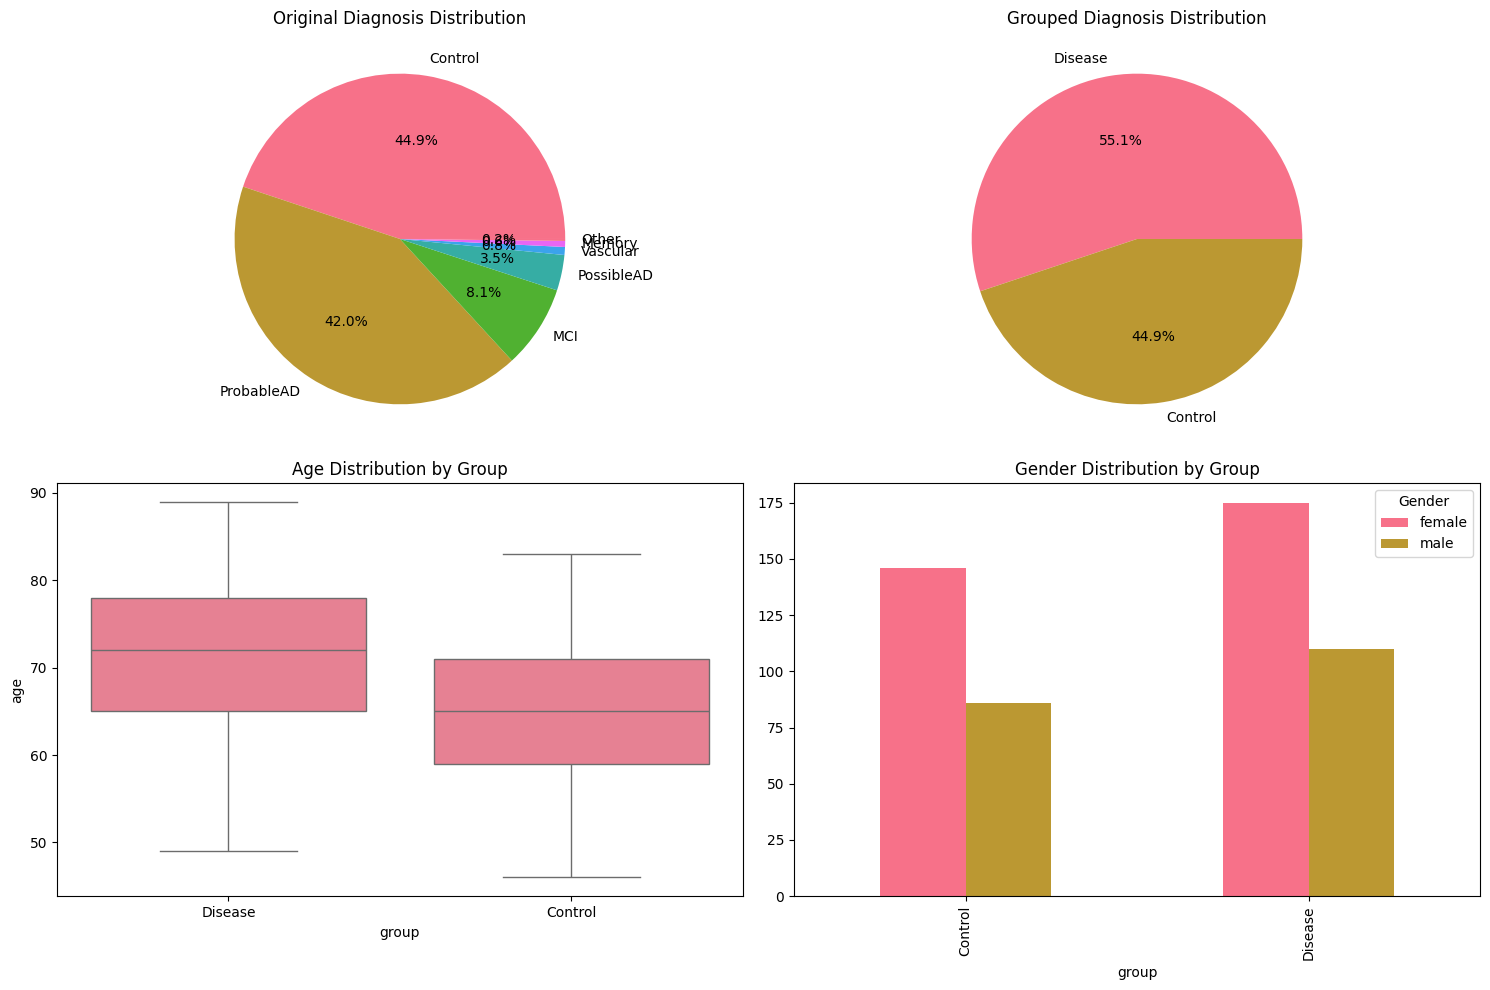


Sample texts from each group:

Control group sample:
Text: the scene is in the kitchen. the mother is wiping dishes and the water is running on the floor. a boy is trying to get cookies uh, the little girl is reacting to his falling. uh, it seems to be summer...
Length: 656 characters

Disease group sample:
Text: mhm. there's a young boy uh, going in a cookie jar. and there's a a girl young girl. and I'm saying he's a boy because it's uh, and he's he's in the cookie jar. and there's a stool that he is on and i...
Length: 516 characters


In [ ]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Examine the distribution of diagnoses
print("\nDiagnosis distribution:")
diagnosis_counts = df['gold_diagnosis'].value_counts()
print(diagnosis_counts)

# Create a new column to group MCI and ProbableAD as 'Disease'
df['group'] = df['gold_diagnosis'].apply(
    lambda x: 'Control' if x == 'Control' else 'Disease')
group_counts = df['group'].value_counts()

print("\nGrouped diagnosis distribution (Control vs Disease):")
print(group_counts)

# Basic statistics
print("\nBasic dataset statistics:")
print(f"Total number of participants: {df['patient_id'].nunique()}")
print(f"Age range: {df['age'].min()} - {df['age'].max()}")
print(f"Gender distribution:")
print(df['gender'].value_counts())

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Diagnosis distribution
axes[0, 0].pie(diagnosis_counts.values,
               labels=diagnosis_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Original Diagnosis Distribution')

# Control vs Disease
axes[0, 1].pie(group_counts.values,
               labels=group_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Grouped Diagnosis Distribution')

# Age distribution by group
sns.boxplot(data=df, x='group', y='age', ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution by Group')

# Gender distribution by group
gender_group = pd.crosstab(df['group'], df['gender'])
gender_group.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Gender Distribution by Group')
axes[1, 1].legend(title='Gender')

plt.tight_layout()
plt.show()

# Display some sample texts
print("\nSample texts from each group:")
for group in ['Control', 'Disease']:
    sample_text = df[df['group'] == group]['text'].iloc[0]
    print(f"\n{group} group sample:")
    print(f"Text: {sample_text[:200]}...")
    print(f"Length: {len(sample_text)} characters")

## 4. Initialize Features DataFrame

Create a new DataFrame to store our linguistic features as we add them one by one.

In [6]:
# Initialize features DataFrame with basic information
features_df = pd.DataFrame({
    'uuid': df['uuid'],
    'patient_id': df['patient_id'],
    'visit_num': df['visit_num'],
    'age': df['age'],
    'gender': df['gender'],
    'text': df['text'],
    'gold_diagnosis': df['gold_diagnosis'],
    'group': df['group']
})

print("Initialized features DataFrame:")
print(f"Shape: {features_df.shape}")
print(f"Columns: {features_df.columns.tolist()}")
print("\nFirst few rows:")
print(features_df.head())

Initialized features DataFrame:
Shape: (517, 8)
Columns: ['uuid', 'patient_id', 'visit_num', 'age', 'gender', 'text', 'gold_diagnosis', 'group']

First few rows:
    uuid  patient_id  visit_num  age  gender  \
0  001-2           1          3   59    male   
1  002-0           2          1   58  female   
2  002-1           2          2   59  female   
3  002-2           2          3   60  female   
4  002-3           2          4   61  female   

                                                text gold_diagnosis    group  
0  mhm. there's a young boy uh, going in a cookie...     ProbableAD  Disease  
1  the scene is in the kitchen. the mother is wip...        Control  Control  
2  oh I see the sink is running over. I see the s...        Control  Control  
3  um a boy and a girl are in the kitchen with th...        Control  Control  
4  okay. it was summertime and mother and the chi...        Control  Control  


## 5. Helper Functions

First, let's define helper functions that will be used across multiple linguistic features.

In [ ]:
# Helper functions for text processing
@lru_cache(maxsize=1000)
def _clean_tokens(text):
    """Clean text and return tokens"""
    if pd.isna(text) or text == "":
        return []

    # Remove brackets and their contents, punctuation except periods
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^\w\s\.]', ' ', text)

    # Tokenize and clean
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and len(token) > 1]

    return tokens


@lru_cache(maxsize=1000)
def _pos_tags(text):
    """Get POS tags for text"""
    if pd.isna(text) or text == "":
        return []

    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    return pos_tags


# Load word frequency data
try:
    subtl_zipf_df = pd.read_csv('subtl_and_zipf.csv')
    print(f"Loaded word frequency data: {subtl_zipf_df.shape[0]} words")

    # Check the actual column names
    print("Available columns:", subtl_zipf_df.columns.tolist())

    # Initialize empty dictionaries as fallback
    subtl_freq_dict = {}
    zipf_freq_dict = {}

    # Try to use the correct column names based on what's available
    if 'Word' in subtl_zipf_df.columns:
        # Try different possible column names for frequency data
        freq_columns = [col for col in subtl_zipf_df.columns if 'freq' in col.lower(
        ) or 'subtl' in col.lower()]
        zipf_columns = [
            col for col in subtl_zipf_df.columns if 'zipf' in col.lower()]

        print(f"Found frequency-related columns: {freq_columns}")
        print(f"Found zipf-related columns: {zipf_columns}")

        # Use SUBTLWF and Zipf-value if available
        if 'SUBTLWF' in subtl_zipf_df.columns:
            subtl_freq_dict = dict(
                zip(subtl_zipf_df['Word'].str.lower(), subtl_zipf_df['SUBTLWF']))
            print("Created SUBTLWF frequency dictionary")

        if 'Zipf-value' in subtl_zipf_df.columns:
            # Handle the zipf column which might have mixed data
            zipf_series = subtl_zipf_df['Zipf-value']
            # Convert to numeric, coercing errors to NaN
            zipf_numeric = pd.to_numeric(zipf_series, errors='coerce')
            # Only use rows where zipf value is valid
            valid_zipf = ~zipf_numeric.isna()
            if valid_zipf.sum() > 0:
                zipf_freq_dict = dict(zip(
                    subtl_zipf_df.loc[valid_zipf, 'Word'].str.lower(),
                    zipf_numeric.loc[valid_zipf]
                ))
                print(
                    f"Created Zipf frequency dictionary with {len(zipf_freq_dict)} valid entries")

        print("Word frequency dictionaries created successfully")
    else:
        print("Warning: Expected column 'Word' not found in CSV file")

except FileNotFoundError:
    print("Warning: subtl_and_zipf.csv not found. Word frequency features will be unavailable.")
    subtl_freq_dict = {}
    zipf_freq_dict = {}
except Exception as e:
    print(f"Warning: Error loading word frequency data: {e}")
    print("Word frequency features will use empty dictionaries.")
    subtl_freq_dict = {}
    zipf_freq_dict = {}

Loaded word frequency data: 74286 words
Available columns: ['Word', 'FREQcount', 'CDcount', 'FREQlow', 'Cdlow', 'SUBTLWF', 'Lg10WF', 'SUBTLCD', 'Lg10CD', 'Dom_PoS_SUBTLEX', 'Freq_dom_PoS_SUBTLEX', 'Percentage_dom_PoS', 'All_PoS_SUBTLEX', 'All_freqs_SUBTLEX', 'Zipf-value']
Found frequency-related columns: ['FREQcount', 'FREQlow', 'SUBTLWF', 'SUBTLCD', 'Dom_PoS_SUBTLEX', 'Freq_dom_PoS_SUBTLEX', 'All_PoS_SUBTLEX', 'All_freqs_SUBTLEX']
Found zipf-related columns: ['Zipf-value']
Created SUBTLWF frequency dictionary
Created Zipf frequency dictionary with 74285 valid entries
Word frequency dictionaries created successfully


In [ ]:
# Reusable functions for feature computation and visualization
def compute_and_visualize_feature(feature_func, feature_name, feature_description, features_df):
    """
    Compute a linguistic feature and create standardized visualizations

    Args:
        feature_func: Function to compute the feature
        feature_name: Column name for the feature
        feature_description: Human-readable description for titles
        features_df: DataFrame containing the text data

    Returns:
        Updated features_df with the new feature column
    """
    # Compute the feature
    print(f"Computing {feature_description}...")
    features_df[feature_name] = features_df['text'].progress_apply(
        feature_func)

    # Display statistics
    print(f"\n{feature_description} Statistics:")
    print(f"Mean: {features_df[feature_name].mean():.4f}")
    print(f"Std: {features_df[feature_name].std():.4f}")

    # Group statistics
    group_stats = features_df.groupby(
        'group')[feature_name].agg(['mean', 'std'])
    print(f"\nBy Group:")
    print(group_stats)

    # Create visualizations with improved colors
    plt.figure(figsize=(14, 5))

    # Custom color palette
    colors = ['#2E86AB', '#A23B72']  # Blue and Magenta

    # Box plot
    plt.subplot(1, 2, 1)
    box_plot = sns.boxplot(data=features_df, x='group',
                           y=feature_name, palette=colors)
    plt.title(f'{feature_description} by Group',
              fontsize=12, fontweight='bold')
    plt.ylabel(feature_description, fontsize=10)
    plt.xlabel('Group', fontsize=10)

    # Histogram
    plt.subplot(1, 2, 2)
    for i, group in enumerate(['Control', 'Disease']):
        group_data = features_df[features_df['group'] == group][feature_name]
        plt.hist(group_data, bins=25, alpha=0.7, label=group,
                 color=colors[i], edgecolor='white', linewidth=0.5)

    plt.title(f'Distribution of {feature_description}',
              fontsize=12, fontweight='bold')
    plt.xlabel(feature_description, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Progress update
    current_features = [col for col in features_df.columns if col not in
                        ['uuid', 'patient_id', 'visit_num', 'age', 'gender', 'text', 'gold_diagnosis', 'group']]
    print(f"\nCurrent features DataFrame shape: {features_df.shape}")
    print(f"Features added so far: {current_features}")

    return features_df


def create_comparison_plots(features_df, feature_name, feature_description):
    """
    Create additional comparison plots for a feature (optional enhanced visualization)
    """
    plt.figure(figsize=(16, 6))

    colors = ['#2E86AB', '#A23B72', '#F18F01',
              '#C73E1D']  # Blue, Magenta, Orange, Red

    # Violin plot by original diagnosis
    plt.subplot(1, 3, 1)
    sns.violinplot(data=features_df, x='gold_diagnosis',
                   y=feature_name, palette=colors)
    plt.title(f'{feature_description}\nby Original Diagnosis',
              fontsize=10, fontweight='bold')
    plt.xticks(rotation=45)

    # Box plot by age groups
    plt.subplot(1, 3, 2)
    features_df['age_group'] = pd.cut(features_df['age'], bins=[
                                      0, 65, 75, 100], labels=['<65', '65-75', '>75'])
    sns.boxplot(data=features_df, x='age_group',
                y=feature_name, hue='group', palette=colors[:2])
    plt.title(f'{feature_description}\nby Age Group',
              fontsize=10, fontweight='bold')

    # Scatter plot: Age vs Feature colored by group
    plt.subplot(1, 3, 3)
    for i, group in enumerate(['Control', 'Disease']):
        group_data = features_df[features_df['group'] == group]
        plt.scatter(group_data['age'], group_data[feature_name],
                    alpha=0.6, label=group, color=colors[i], s=30)

    plt.xlabel('Age', fontsize=10)
    plt.ylabel(feature_description, fontsize=10)
    plt.title(f'{feature_description} vs Age', fontsize=10, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Update matplotlib and seaborn style for better looking plots
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

print("Visualization functions created successfully!")
print("Updated plotting style with improved colors and formatting.")

Visualization functions created successfully!
Updated plotting style with improved colors and formatting.


## 6. Feature 1: Noun Token Ratio

This feature measures the proportion of nouns in the text, which can indicate semantic content density.

Computing Noun Token Ratio...


100%|██████████| 517/517 [00:01<00:00, 469.01it/s]
/var/folders/yb/mjndz8pn01d7p4kc_8gv556c0000gn/T/ipykernel_17596/3184392614.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(data=features_df, x='group', y=feature_name, palette=colors)



Noun Token Ratio Statistics:
Mean: 0.2315
Std: 0.0486

By Group:
             mean       std
group                      
Control  0.241876  0.040799
Disease  0.223144  0.052654


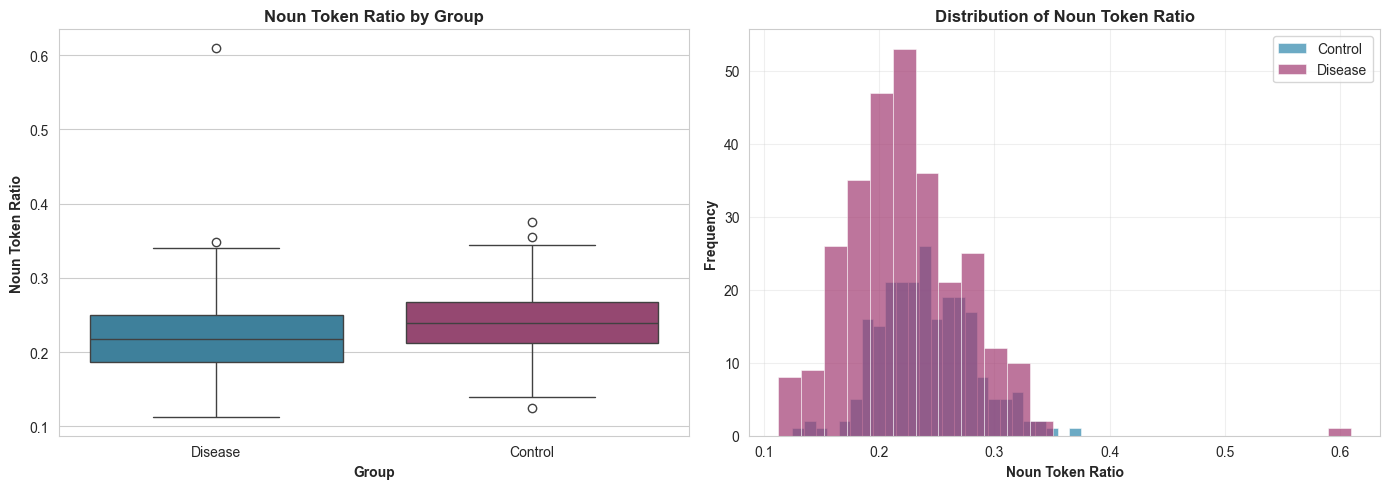


Current features DataFrame shape: (517, 9)
Features added so far: ['noun_token_ratio']


In [9]:
# Use the reusable function for computation and visualization
features_df = compute_and_visualize_feature(
    feature_func=noun_token_ratio,
    feature_name='noun_token_ratio',
    feature_description='Noun Token Ratio',
    features_df=features_df
)

## 7. Feature 2: Hapax Legomena Ratio

Hapax legomena are words that occur only once in a text. This feature measures lexical diversity and vocabulary richness.

Computing Hapax Legomena Ratio...


100%|██████████| 517/517 [00:00<00:00, 3038.98it/s]


Hapax Legomena Ratio Statistics:
Mean: 0.4628
Std: 0.1219

By Group:
             mean       std
group                      
Control  0.472764  0.112612
Disease  0.454603  0.128593



/var/folders/yb/mjndz8pn01d7p4kc_8gv556c0000gn/T/ipykernel_17596/3184392614.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(data=features_df, x='group', y=feature_name, palette=colors)


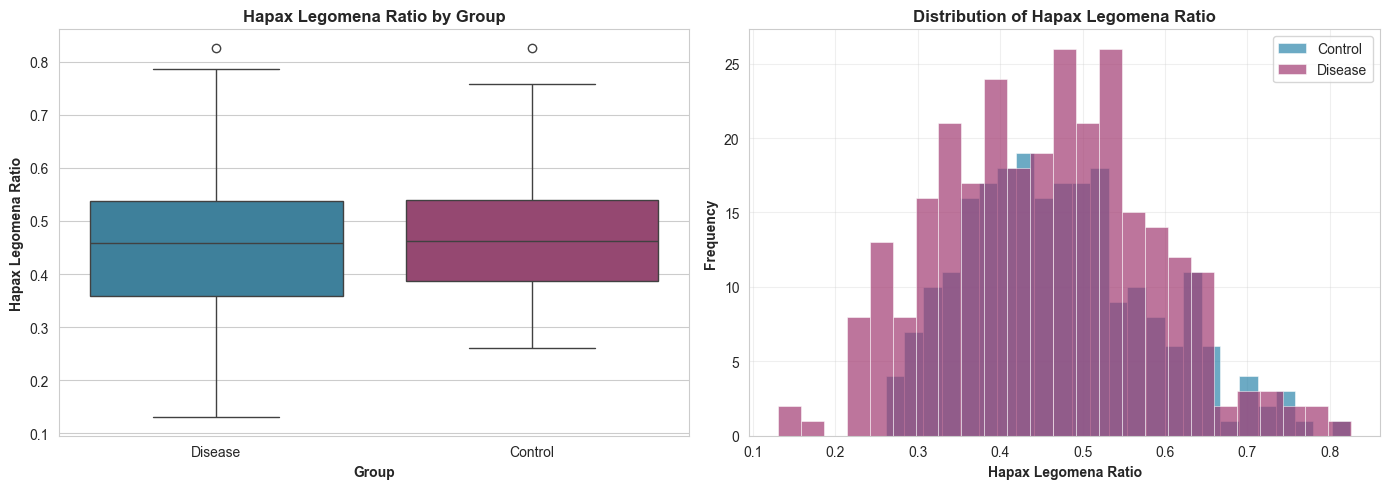


Current features DataFrame shape: (517, 10)
Features added so far: ['noun_token_ratio', 'hapax_legomena_ratio']


In [10]:
# Use the reusable function for computation and visualization
features_df = compute_and_visualize_feature(
    feature_func=hapax_legomena_ratio,
    feature_name='hapax_legomena_ratio',
    feature_description='Hapax Legomena Ratio',
    features_df=features_df
)

## 8. Feature 3: Word Used Once or Twice Frequency

This feature measures the frequency of words that appear only once or twice in the text, related to lexical diversity.

Computing Word Used Once or Twice Frequency...


100%|██████████| 517/517 [00:00<00:00, 3260.26it/s]


Word Used Once or Twice Frequency Statistics:
Mean: 0.5618
Std: 0.1139

By Group:
             mean       std
group                      
Control  0.567458  0.103307
Disease  0.557233  0.121806



/var/folders/yb/mjndz8pn01d7p4kc_8gv556c0000gn/T/ipykernel_17596/3184392614.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(data=features_df, x='group', y=feature_name, palette=colors)


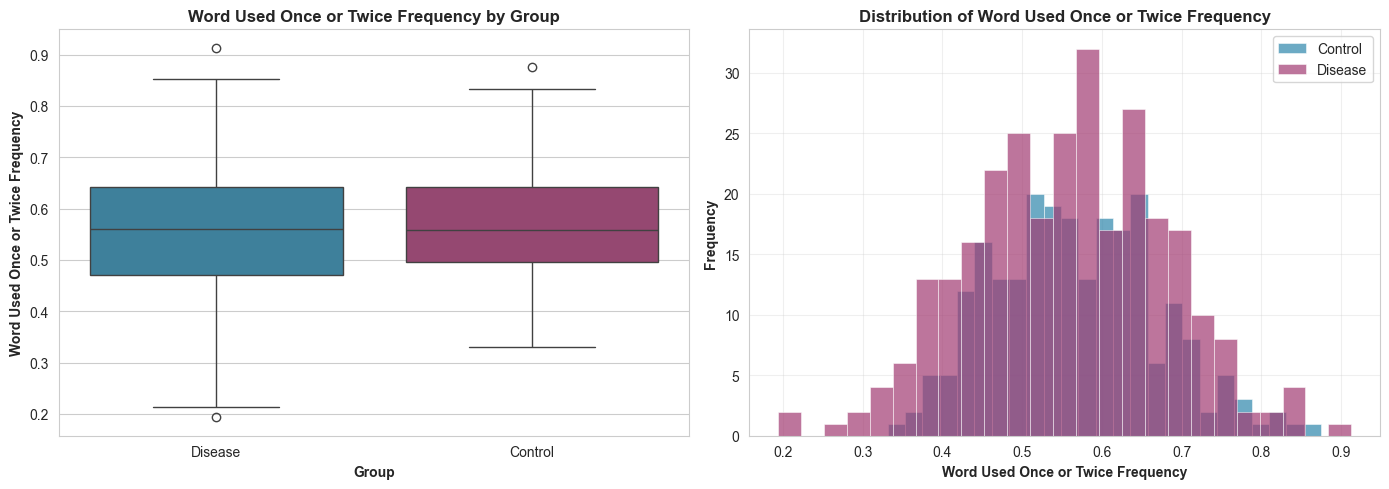


Current features DataFrame shape: (517, 11)
Features added so far: ['noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency']


In [11]:
# Use the reusable function for computation and visualization
features_df = compute_and_visualize_feature(
    feature_func=word_used_once_or_twice_frequency,
    feature_name='word_used_once_or_twice_frequency',
    feature_description='Word Used Once or Twice Frequency',
    features_df=features_df
)

## 9. Feature 4: Brunet Index

The Brunet Index is a measure of lexical diversity that accounts for text length variation.

Computing Brunet Index...


100%|██████████| 517/517 [00:00<00:00, 3068.70it/s]


Brunet Index Statistics:
Mean: 9.9362
Std: 1.1748

By Group:
             mean       std
group                      
Control  9.992247  1.037657
Disease  9.890616  1.275598



/var/folders/yb/mjndz8pn01d7p4kc_8gv556c0000gn/T/ipykernel_17596/3184392614.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(data=features_df, x='group', y=feature_name, palette=colors)


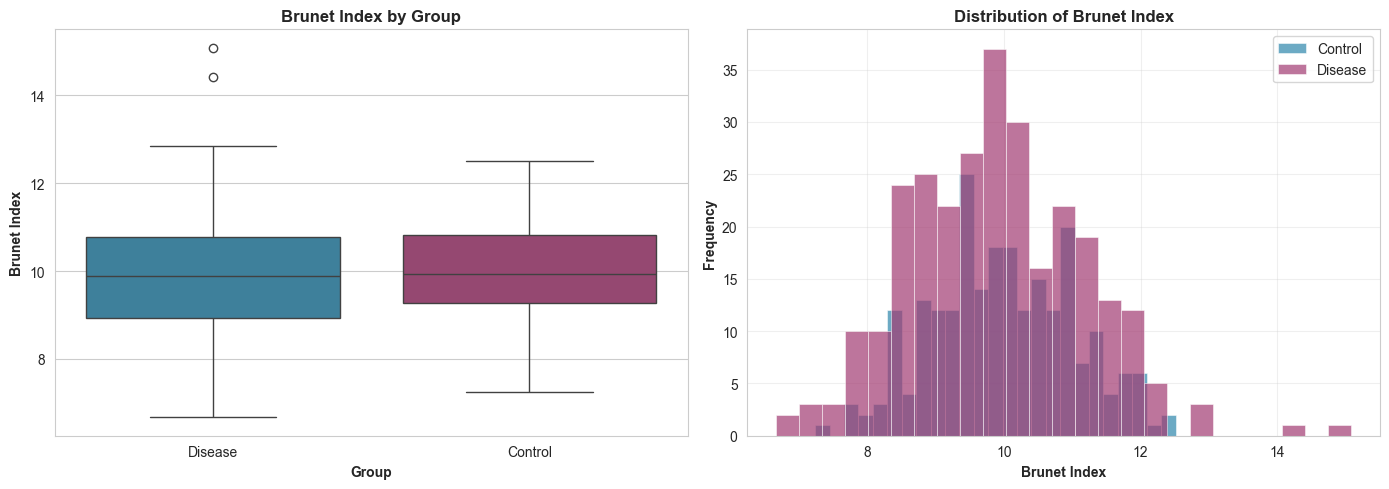


Current features DataFrame shape: (517, 12)
Features added so far: ['noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency', 'brunet_index']


In [12]:
# Use the reusable function for computation and visualization
features_df = compute_and_visualize_feature(
    feature_func=brunet_index,
    feature_name='brunet_index',
    feature_description='Brunet Index',
    features_df=features_df
)

## 10. Feature 5: Token Type Ratio (TTR)

The Type-Token Ratio measures lexical diversity by comparing unique words to total words.

Computing Token Type Ratio...


100%|██████████| 517/517 [00:00<00:00, 3466.73it/s]


Token Type Ratio Statistics:
Mean: 0.6313
Std: 0.0954

By Group:
             mean       std
group                      
Control  0.634616  0.087848
Disease  0.628618  0.101228



/var/folders/yb/mjndz8pn01d7p4kc_8gv556c0000gn/T/ipykernel_17596/3184392614.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(data=features_df, x='group', y=feature_name, palette=colors)


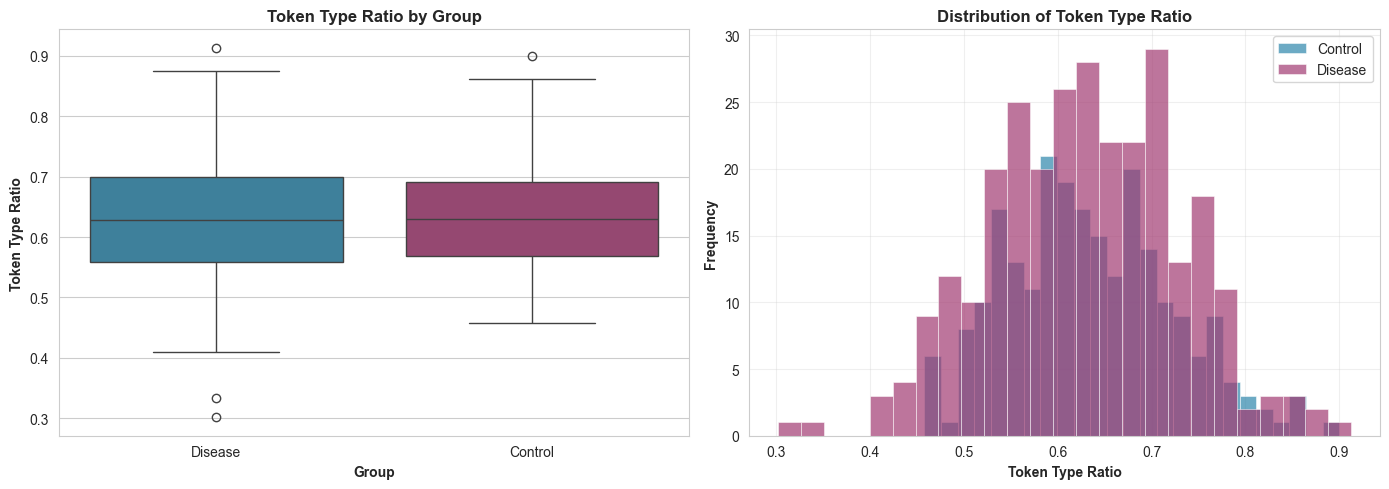


Current features DataFrame shape: (517, 13)
Features added so far: ['noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency', 'brunet_index', 'token_type_ratio']


In [13]:
# Use the reusable function for computation and visualization
features_df = compute_and_visualize_feature(
    feature_func=token_type_ratio,
    feature_name='token_type_ratio',
    feature_description='Token Type Ratio',
    features_df=features_df
)

## 11. Feature 6: Adposition Frequency

This feature measures the frequency of adpositions (prepositions and postpositions) in the text.

Computing Adposition Frequency...


100%|██████████| 517/517 [00:00<00:00, 3496.50it/s]


Adposition Frequency Statistics:
Mean: 0.1238
Std: 0.0363

By Group:
             mean       std
group                      
Control  0.131274  0.034145
Disease  0.117796  0.036952



/var/folders/yb/mjndz8pn01d7p4kc_8gv556c0000gn/T/ipykernel_17596/3184392614.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(data=features_df, x='group', y=feature_name, palette=colors)


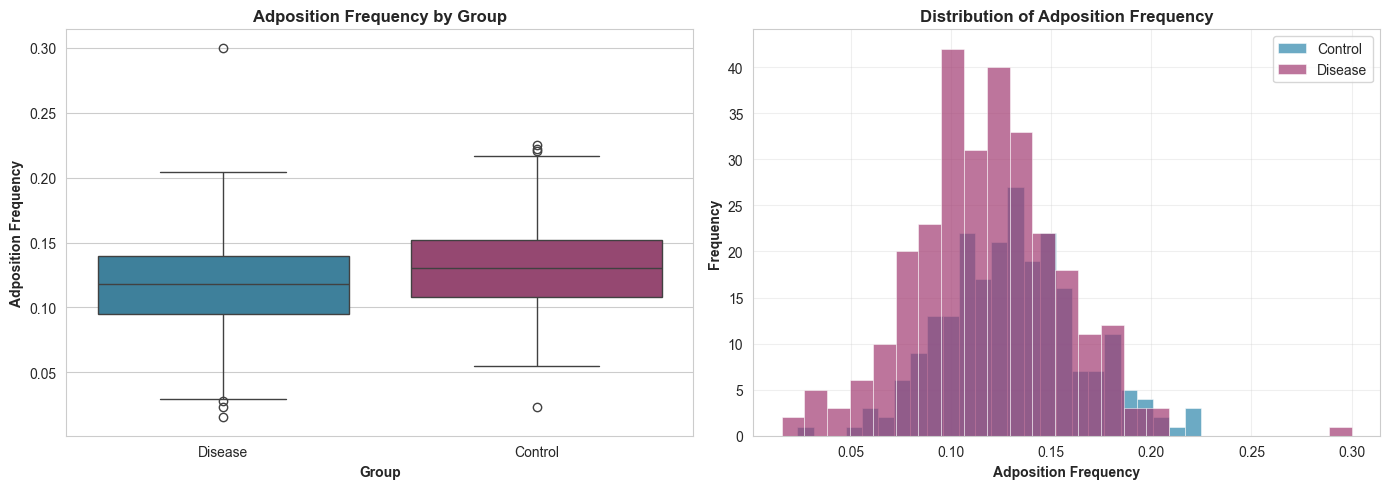


Current features DataFrame shape: (517, 14)
Features added so far: ['noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency', 'brunet_index', 'token_type_ratio', 'adposition_frequency']


In [14]:
# Use the reusable function for computation and visualization
features_df = compute_and_visualize_feature(
    feature_func=adposition_frequency,
    feature_name='adposition_frequency',
    feature_description='Adposition Frequency',
    features_df=features_df
)

## 12. Feature 7: Unigram and Bigram Repetitions

This feature counts repetitive patterns in unigrams and bigrams, which can indicate speech disfluencies.

Computing Unigram and Bigram Repetitions...


100%|██████████| 517/517 [00:00<00:00, 1615.17it/s]
/var/folders/yb/mjndz8pn01d7p4kc_8gv556c0000gn/T/ipykernel_17596/3184392614.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(data=features_df, x='group', y=feature_name, palette=colors)



Unigram and Bigram Repetitions Statistics:
Mean: 154.6267
Std: 62.3569

By Group:
               mean        std
group                         
Control  160.814655  63.112866
Disease  149.589474  61.385441


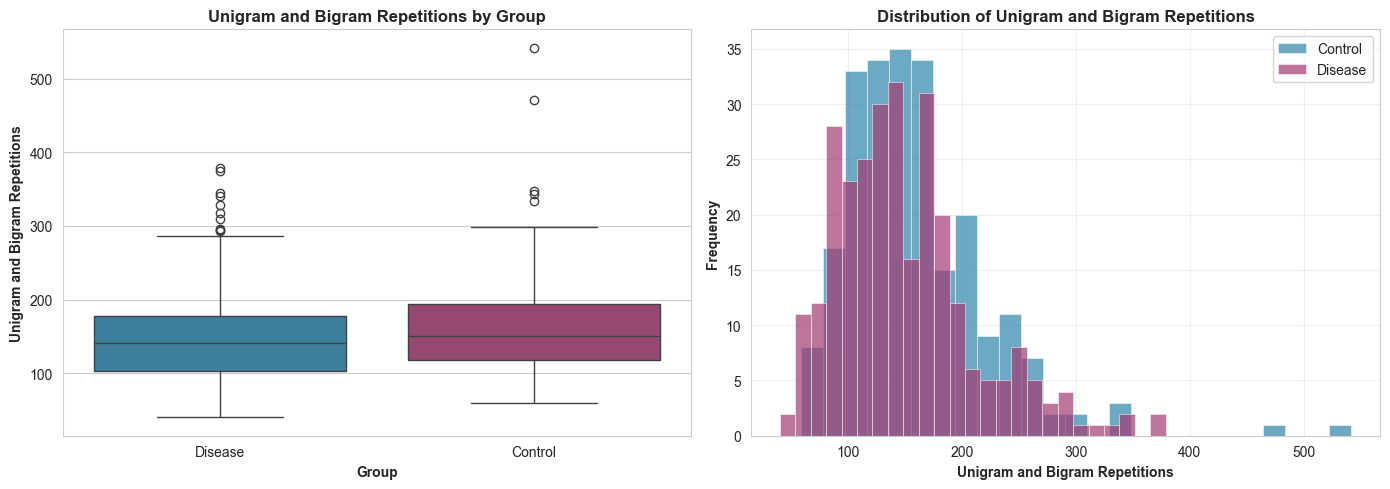


Current features DataFrame shape: (517, 15)
Features added so far: ['noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency', 'brunet_index', 'token_type_ratio', 'adposition_frequency', 'uni_and_bi_grams_repetitions']


In [15]:
# Use the reusable function for computation and visualization
features_df = compute_and_visualize_feature(
    feature_func=uni_and_bi_grams_repetitions,
    feature_name='uni_and_bi_grams_repetitions',
    feature_description='Unigram and Bigram Repetitions',
    features_df=features_df
)

## 13. Feature 8: Word Frequency (SUBTL)

This feature uses the SUBTL word frequency database to calculate average word frequency in the text.

Computing Word Frequency (SUBTL)...


100%|██████████| 517/517 [01:15<00:00,  6.88it/s]
/var/folders/yb/mjndz8pn01d7p4kc_8gv556c0000gn/T/ipykernel_17596/3184392614.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(data=features_df, x='group', y=feature_name, palette=colors)



Word Frequency (SUBTL) Statistics:
Mean: 7254.9742
Std: 1107.4092

By Group:
                mean          std
group                            
Control  7355.990586   942.837867
Disease  7172.743337  1220.653788


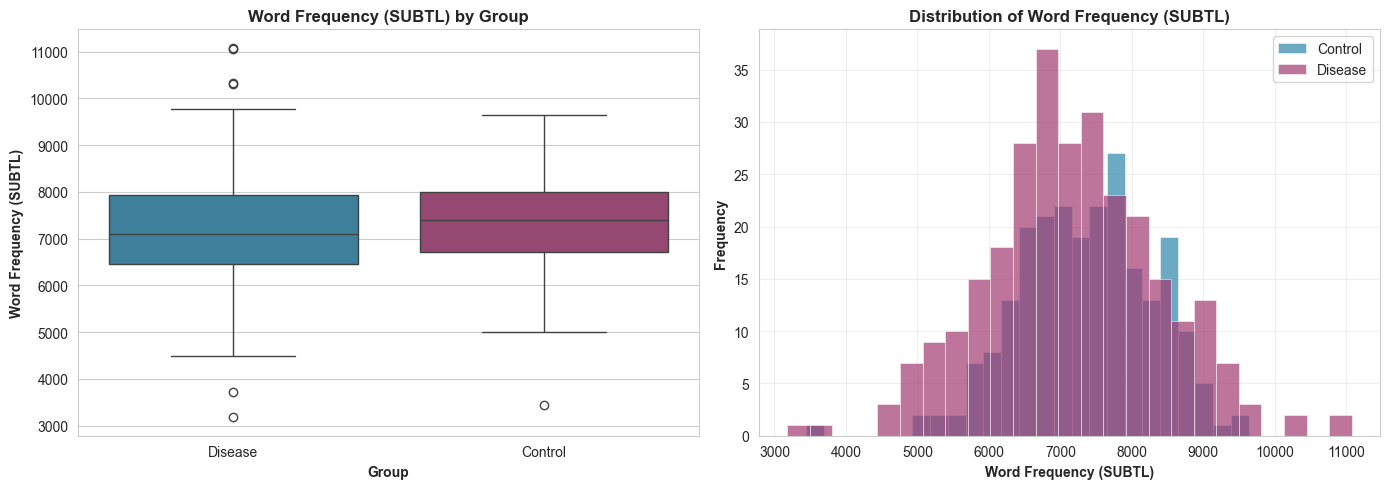


Current features DataFrame shape: (517, 16)
Features added so far: ['noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency', 'brunet_index', 'token_type_ratio', 'adposition_frequency', 'uni_and_bi_grams_repetitions', 'word_freq_subtl']


In [16]:
# Use the reusable function for computation and visualization
features_df = compute_and_visualize_feature(
    feature_func=lambda text: word_freq_subtl(text, subtl_zipf_df),
    feature_name='word_freq_subtl',
    feature_description='Word Frequency (SUBTL)',
    features_df=features_df
)

## 14. Feature 9: Word Frequency (Zipf)

This is the final linguistic feature using the Zipf word frequency scale.

Computing Word Frequency (Zipf)...


100%|██████████| 517/517 [01:16<00:00,  6.79it/s]
/var/folders/yb/mjndz8pn01d7p4kc_8gv556c0000gn/T/ipykernel_17596/3184392614.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(data=features_df, x='group', y=feature_name, palette=colors)



Word Frequency (Zipf) Statistics:
Mean: 5.9020
Std: 0.1818

By Group:
             mean       std
group                      
Control  5.889825  0.163071
Disease  5.911996  0.195413


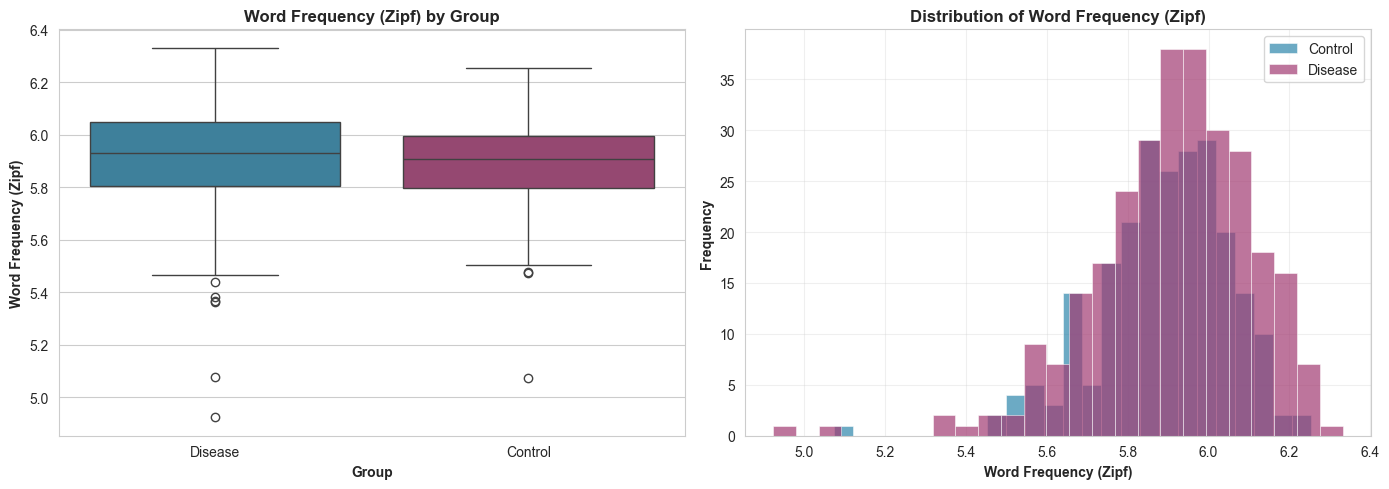


Current features DataFrame shape: (517, 17)
Features added so far: ['noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency', 'brunet_index', 'token_type_ratio', 'adposition_frequency', 'uni_and_bi_grams_repetitions', 'word_freq_subtl', 'word_freq_zipf']

Final features DataFrame shape: (517, 17)
All 9 linguistic features added: ['noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency', 'brunet_index', 'token_type_ratio', 'adposition_frequency', 'uni_and_bi_grams_repetitions', 'word_freq_subtl', 'word_freq_zipf']


In [ ]:
# Use the reusable function for computation and visualization
features_df = compute_and_visualize_feature(
    feature_func=lambda text: word_freq_zipf(text, subtl_zipf_df),
    feature_name='word_freq_zipf',
    feature_description='Word Frequency (Zipf)',
    features_df=features_df
)

print(f"\nFinal features DataFrame shape: {features_df.shape}")
linguistic_features = [col for col in features_df.columns if col not in [
    'uuid', 'patient_id', 'visit_num', 'age', 'gender', 'text', 'gold_diagnosis', 'group']]
print(f"All 9 linguistic features added: {linguistic_features}")

## 15. Compare Disease Groups vs Control Group

Now that we have all 9 linguistic features, let's analyze the differences between the control group and disease groups (MCI and Probable AD).

In [ ]:
# Get linguistic features columns
import warnings
from IPython.display import display, HTML
linguistic_features = [
    'noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency',
    'brunet_index', 'token_type_ratio', 'adposition_frequency',
    'uni_and_bi_grams_repetitions', 'word_freq_subtl', 'word_freq_zipf'
]

# Create comprehensive comparison with improved presentation

# Check if jinja2 is available for styling
try:
    import jinja2
    STYLING_AVAILABLE = True
except ImportError:
    STYLING_AVAILABLE = False
    print("Note: Advanced table styling requires jinja2. Install it with: pip install jinja2")

print("=== COMPREHENSIVE GROUP COMPARISON ===\n")

# 1. Display sample sizes first
print("1. SAMPLE SIZES:")

# Create sample size DataFrames
group_sizes = pd.DataFrame({
    'Group': features_df['group'].value_counts().index,
    'Count': features_df['group'].value_counts().values,
    'Percentage': (features_df['group'].value_counts().values / len(features_df) * 100).round(1)
})

diagnosis_sizes = pd.DataFrame({
    'Diagnosis': features_df['gold_diagnosis'].value_counts().index,
    'Count': features_df['gold_diagnosis'].value_counts().values,
    'Percentage': (features_df['gold_diagnosis'].value_counts().values / len(features_df) * 100).round(1)
})

# Style sample sizes
try:
    styled_groups = group_sizes.style\
        .background_gradient(cmap='Blues', subset=['Count'])\
        .format({'Percentage': '{:.1f}%'})\
        .set_caption("Sample Distribution by Group")\
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('font-weight', 'bold'), ('font-size', '14px')]},
            {'selector': 'th', 'props': [
                ('background-color', '#6C757D'), ('color', 'white'), ('font-weight', 'bold')]},
            {'selector': 'td', 'props': [('text-align', 'center')]}
        ])

    styled_diagnoses = diagnosis_sizes.style\
        .background_gradient(cmap='Oranges', subset=['Count'])\
        .format({'Percentage': '{:.1f}%'})\
        .set_caption("Sample Distribution by Original Diagnosis")\
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('font-weight', 'bold'), ('font-size', '14px')]},
            {'selector': 'th', 'props': [
                ('background-color', '#6C757D'), ('color', 'white'), ('font-weight', 'bold')]},
            {'selector': 'td', 'props': [('text-align', 'center')]}
        ])

    display(styled_groups)
    display(styled_diagnoses)
except Exception as e:
    print("Using fallback display method...")
    print("\n📊 Sample Distribution by Group:")
    display(group_sizes)
    print("\n📊 Sample Distribution by Original Diagnosis:")
    display(diagnosis_sizes)

# 2. Overall statistics by group (without count columns)
print("\n2. OVERALL STATISTICS BY GROUP:")
group_comparison = features_df.groupby(
    'group')[linguistic_features].agg(['mean', 'std']).round(4)

# Try advanced styling, fallback to simple display if needed
try:
    # Style the DataFrame
    styled_group = group_comparison.style\
        .format(precision=4)\
        .background_gradient(cmap='RdYlBu_r', subset=pd.IndexSlice[:, pd.IndexSlice[:, 'mean']])\
        .set_caption("Group Statistics: Mean values are color-coded (red=high, blue=low)")\
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('font-weight', 'bold'), ('font-size', '14px')]},
            {'selector': 'th', 'props': [
                ('background-color', '#6C757D'), ('color', 'white'), ('font-weight', 'bold')]},
            {'selector': 'td', 'props': [('text-align', 'center')]}
        ])

    display(styled_group)
except Exception as e:
    print("Using fallback display method...")
    print("\n📊 Group Statistics Summary:")
    print("="*60)
    display(group_comparison)

# 3. Detailed breakdown by original diagnosis (without count columns)
print(f"\n3. DETAILED BREAKDOWN BY ORIGINAL DIAGNOSIS:")
diagnosis_comparison = features_df.groupby(
    'gold_diagnosis')[linguistic_features].agg(['mean', 'std']).round(4)

try:
    styled_diagnosis = diagnosis_comparison.style\
        .format(precision=4)\
        .background_gradient(cmap='viridis', subset=pd.IndexSlice[:, pd.IndexSlice[:, 'mean']])\
        .set_caption("Diagnosis Statistics: Mean values by original diagnosis")\
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('font-weight', 'bold'), ('font-size', '14px')]},
            {'selector': 'th', 'props': [
                ('background-color', '#6C757D'), ('color', 'white'), ('font-weight', 'bold')]},
            {'selector': 'td', 'props': [('text-align', 'center')]}
        ])

    display(styled_diagnosis)
except Exception as e:
    print("Using fallback display method...")
    print("\n📊 Diagnosis Statistics Summary:")
    print("="*60)
    display(diagnosis_comparison)

# 4. Control vs Disease summary with enhanced styling
print(f"\n4. CONTROL VS DISEASE SUMMARY:")
summary_stats = []

for feature in linguistic_features:
    control_mean = features_df[features_df['group']
                               == 'Control'][feature].mean()
    control_std = features_df[features_df['group'] == 'Control'][feature].std()
    disease_mean = features_df[features_df['group']
                               == 'Disease'][feature].mean()
    disease_std = features_df[features_df['group'] == 'Disease'][feature].std()

    difference = disease_mean - control_mean
    percent_change = (difference / control_mean *
                      100) if control_mean != 0 else 0

    summary_stats.append({
        'Feature': feature.replace('_', ' ').title(),
        'Control Mean': round(control_mean, 4),
        'Control Std': round(control_std, 4),
        'Disease Mean': round(disease_mean, 4),
        'Disease Std': round(disease_std, 4),
        'Difference': round(difference, 4),
        'Percent Change': round(percent_change, 2)
    })

summary_df = pd.DataFrame(summary_stats)

# Enhanced styling for summary table


def highlight_differences(val):
    """Highlight positive and negative differences"""
    if isinstance(val, (int, float)):
        if val > 0:
            return 'background-color: #ffcccc'  # Light red for positive
        elif val < 0:
            return 'background-color: #ccffcc'  # Light green for negative
    return ''


try:
    styled_summary = summary_df.style\
        .format({'Control Mean': '{:.4f}', 'Control Std': '{:.4f}',
                 'Disease Mean': '{:.4f}', 'Disease Std': '{:.4f}',
                 'Difference': '{:.4f}', 'Percent Change': '{:.2f}%'})\
        .map(highlight_differences, subset=['Difference', 'Percent Change'])\
        .background_gradient(cmap='RdBu_r', subset=['Control Mean', 'Disease Mean'])\
        .set_caption("Feature Comparison: Control vs Disease Groups (Green=Disease Lower, Red=Disease Higher)")\
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('font-weight', 'bold'), ('font-size', '14px'), ('margin-bottom', '10px')]},
            {'selector': 'th', 'props': [
                ('background-color', '#6C757D'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'td', 'props': [
                ('text-align', 'center'), ('padding', '8px')]},
            {'selector': 'table', 'props': [
                ('border-collapse', 'collapse'), ('width', '100%')]}
        ])

    display(styled_summary)
except Exception as e:
    print("Using fallback display method...")
    print("\n📊 Feature Comparison Summary:")
    print("="*80)
    print("🔹 Positive differences mean Disease group has higher values")
    print("🔸 Negative differences mean Control group has higher values")
    print("="*80)

    # Format the dataframe for better readability
    formatted_summary = summary_df.copy()
    formatted_summary['Percent Change'] = formatted_summary['Percent Change'].apply(
        lambda x: f"{x:.2f}%")

    display(formatted_summary)

=== COMPREHENSIVE GROUP COMPARISON ===

1. SAMPLE SIZES:


,Group,Count,Percentage
0,Disease,285,55.1%
1,Control,232,44.9%


,Diagnosis,Count,Percentage
0,Control,232,44.9%
1,ProbableAD,217,42.0%
2,MCI,42,8.1%
3,PossibleAD,18,3.5%
4,Vascular,4,0.8%
5,Memory,3,0.6%
6,Other,1,0.2%



2. OVERALL STATISTICS BY GROUP:



3. DETAILED BREAKDOWN BY ORIGINAL DIAGNOSIS:



4. CONTROL VS DISEASE SUMMARY:


,Feature,Control Mean,Control Std,Disease Mean,Disease Std,Difference,Percent Change
0,Noun Token Ratio,0.2419,0.0408,0.2231,0.0527,-0.0187,-7.74%
1,Hapax Legomena Ratio,0.4728,0.1126,0.4546,0.1286,-0.0182,-3.84%
2,Word Used Once Or Twice Frequency,0.5675,0.1033,0.5572,0.1218,-0.0102,-1.80%
3,Brunet Index,9.9922,1.0377,9.8906,1.2756,-0.1016,-1.02%
4,Token Type Ratio,0.6346,0.0878,0.6286,0.1012,-0.0060,-0.95%
5,Adposition Frequency,0.1313,0.0341,0.1178,0.0370,-0.0135,-10.27%
6,Uni And Bi Grams Repetitions,160.8147,63.1129,149.5895,61.3854,-11.2252,-6.98%
7,Word Freq Subtl,7355.9906,942.8379,7172.7433,1220.6538,-183.2472,-2.49%
8,Word Freq Zipf,5.8898,0.1631,5.9120,0.1954,0.0222,0.38%


## 16. Statistical Analysis and Visualization

Let's perform statistical tests and create comprehensive visualizations to understand the differences between groups.

In [ ]:
# Statistical Tests
print("=== STATISTICAL TESTS ===\n")

# Perform t-tests for each feature
statistical_results = []

for feature in linguistic_features:
    control_data = features_df[features_df['group']
                               == 'Control'][feature].dropna()
    disease_data = features_df[features_df['group']
                               == 'Disease'][feature].dropna()

    # Perform t-test
    t_stat, p_value = ttest_ind(control_data, disease_data)

    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt(((len(control_data) - 1) * control_data.var() +
                         (len(disease_data) - 1) * disease_data.var()) /
                         (len(control_data) + len(disease_data) - 2))
    cohens_d = (control_data.mean() - disease_data.mean()) / pooled_std

    # Determine significance
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""

    statistical_results.append({
        'Feature': feature,
        'T_Statistic': round(t_stat, 4),
        'P_Value': round(p_value, 6),
        'Cohens_D': round(cohens_d, 4),
        'Significance': significance
    })

stats_df = pd.DataFrame(statistical_results)
print("T-TEST RESULTS (Control vs Disease):")
print("="*50)
print(stats_df.to_string(index=False))

print(f"\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05")

# Effect size interpretation


def interpret_effect_size(d):
    abs_d = abs(d)
    if abs_d < 0.2:
        return "negligible"
    elif abs_d < 0.5:
        return "small"
    elif abs_d < 0.8:
        return "medium"
    else:
        return "large"


stats_df['Effect_Size_Interpretation'] = stats_df['Cohens_D'].apply(
    interpret_effect_size)
print(f"\nEFFECT SIZES:")
print("="*20)
for _, row in stats_df.iterrows():
    print(
        f"{row['Feature']}: {row['Effect_Size_Interpretation']} (d={row['Cohens_D']})")

=== STATISTICAL TESTS ===

T-TEST RESULTS (Control vs Disease):
                          Feature  T_Statistic  P_Value  Cohens_D Significance
                 noun_token_ratio       4.4409 0.000011    0.3927          ***
             hapax_legomena_ratio       1.6878 0.092056    0.1492             
word_used_once_or_twice_frequency       1.0154 0.310395    0.0898             
                     brunet_index       0.9783 0.328390    0.0865             
                 token_type_ratio       0.7105 0.477701    0.0628             
             adposition_frequency       4.2674 0.000024    0.3774          ***
     uni_and_bi_grams_repetitions       2.0420 0.041658    0.1806            *
                  word_freq_subtl       1.8759 0.061235    0.1659             
                   word_freq_zipf      -1.3805 0.168028   -0.1221             

Significance levels: *** p<0.001, ** p<0.01, * p<0.05

EFFECT SIZES:
noun_token_ratio: small (d=0.3927)
hapax_legomena_ratio: negligible (d=0.149

## 17. Summary and Export Results

Let's save our results and provide a summary of the findings.

In [ ]:
# Save the complete features dataset
features_df.to_csv(get_output_path(
    'pitt_linguistic_features_complete.csv'), index=False)
print(
    f"Complete features dataset saved as '{get_output_path('pitt_linguistic_features_complete.csv')}'")

# Save statistical results
stats_df.to_csv(get_output_path(
    'statistical_analysis_results.csv'), index=False)
summary_df.to_csv(get_output_path('group_comparison_summary.csv'), index=False)
print(
    f"Statistical results saved as '{get_output_path('statistical_analysis_results.csv')}'")
print(
    f"Group comparison saved as '{get_output_path('group_comparison_summary.csv')}')")

# Final Summary
print("\n" + "="*60)
print("                 FINAL SUMMARY")
print("="*60)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total samples: {len(features_df)}")
print(
    f"   • Control samples: {len(features_df[features_df['group'] == 'Control'])}")
print(
    f"   • Disease samples: {len(features_df[features_df['group'] == 'Disease'])}")
print(f"   • Linguistic features extracted: {len(linguistic_features)}")

print(f"\n🔍 KEY FINDINGS:")
# Find most discriminative features
significant_features = stats_df[stats_df['P_Value'] < 0.05]
if len(significant_features) > 0:
    print(f"   • {len(significant_features)} features show statistically significant differences (p < 0.05)")

    # Top discriminative features by effect size
    top_features = significant_features.nlargest(3, 'Cohens_D', keep='all')
    print(f"   • Most discriminative features:")
    for _, row in top_features.iterrows():
        direction = "higher" if row['Cohens_D'] > 0 else "lower"
        print(
            f"     - {row['Feature']}: {direction} in controls (d={row['Cohens_D']:.3f}, p={row['P_Value']:.4f})")
else:
    print("   • No features show statistically significant differences")

print(f"\n📈 EFFECT SIZES:")
large_effects = stats_df[abs(stats_df['Cohens_D']) >= 0.8]
medium_effects = stats_df[(abs(stats_df['Cohens_D']) >= 0.5) & (
    abs(stats_df['Cohens_D']) < 0.8)]
small_effects = stats_df[(abs(stats_df['Cohens_D']) >= 0.2) & (
    abs(stats_df['Cohens_D']) < 0.5)]

print(f"   • Large effects (|d| ≥ 0.8): {len(large_effects)} features")
print(f"   • Medium effects (0.5 ≤ |d| < 0.8): {len(medium_effects)} features")
print(f"   • Small effects (0.2 ≤ |d| < 0.5): {len(small_effects)} features")

print(f"\n💾 OUTPUTS GENERATED:")
print(
    f"   • Complete features dataset: {get_output_path('pitt_linguistic_features_complete.csv')}")
print(
    f"   • Statistical analysis results: {get_output_path('statistical_analysis_results.csv')}")
print(
    f"   • Group comparison summary: {get_output_path('group_comparison_summary.csv')}")
print(f"   • Multiple visualizations displayed above")

print(f"\n🎯 RESEARCH IMPLICATIONS:")
print("   This analysis provides a comprehensive linguistic profile for")
print("   distinguishing between healthy controls and individuals with")
print("   cognitive impairment (MCI and Probable AD) based on speech patterns")
print("   from the Cookie Theft picture description task.")

print("\n" + "="*60)
print("Analysis completed successfully!")
print("="*60)

Complete features dataset saved as 'pitt vs story comprasions/pitt_linguistic_features_complete.csv'
Statistical results saved as 'pitt vs story comprasions/statistical_analysis_results.csv'
Group comparison saved as 'pitt vs story comprasions/group_comparison_summary.csv')

                 FINAL SUMMARY

📊 DATASET OVERVIEW:
   • Total samples: 517
   • Control samples: 232
   • Disease samples: 285
   • Linguistic features extracted: 9

🔍 KEY FINDINGS:
   • 3 features show statistically significant differences (p < 0.05)
   • Most discriminative features:
     - noun_token_ratio: higher in controls (d=0.393, p=0.0000)
     - adposition_frequency: higher in controls (d=0.377, p=0.0000)
     - uni_and_bi_grams_repetitions: higher in controls (d=0.181, p=0.0417)

📈 EFFECT SIZES:
   • Large effects (|d| ≥ 0.8): 0 features
   • Medium effects (0.5 ≤ |d| < 0.8): 0 features
   • Small effects (0.2 ≤ |d| < 0.5): 2 features

💾 OUTPUTS GENERATED:
   • Complete features dataset: pitt vs story c

## 18. Load and Process Story Data from JSON Files

Now let's load the JSON story data:
- **Disease group**: from `stories/data_oct_6/dementia/` 
- **Control group**: from `stories/data_oct_6/healthyAging/`

Then apply the same linguistic analysis for comparison with the Pitt corpus results.

In [ ]:
import json
import os
import glob
import pandas as pd

# Load JSON story data


def load_story_data():
    """Load and process JSON story files - disease from data_oct_6, control from data_31_07"""

    # Paths to the data folders
    dementia_folder = "stories/data_oct_10/dementia/"
    healthy_folder = "stories/data_oct_6/healthyAging/"

    story_data = []
    # Process dementia files (Disease group) from data_oct_10
    print(f"Loading dementia stories from {dementia_folder}...")
    for filename in os.listdir(dementia_folder):
        if filename.endswith('.json') and filename != 'example.json':
            filepath = os.path.join(dementia_folder, filename)
            with open(filepath, 'r') as f:
                data = json.load(f)

            # Extract name and stories
            name = data.get('name', filename.replace('.json', ''))
            stories = data.get('stories', [])

            for i, story_entry in enumerate(stories):
                story_data.append({
                    'story_id': f"{name}_{i}",
                    'participant_name': name,
                    'age': story_entry.get('age', 'unknown'),
                    'text': story_entry.get('story', ''),
                    'group': 'Disease',
                    'source': 'story_data'
                })

    # Process healthy files (Control group) from data_oct_6/healthyAging
    print("Loading healthy stories from data_oct_6/healthyAging...")
    for filename in os.listdir(healthy_folder):
        if filename.endswith('.json') and filename != 'example.json':
            filepath = os.path.join(healthy_folder, filename)
            with open(filepath, 'r') as f:
                data = json.load(f)

            # Extract name and stories (same structure as dementia files)
            name = data.get('name', filename.replace('.json', ''))
            stories = data.get('stories', [])

            for i, story_entry in enumerate(stories):
                story_data.append({
                    'story_id': f"{name}_{i}",
                    'participant_name': name,
                    'age': story_entry.get('age', 'unknown'),
                    'text': story_entry.get('story', ''),
                    'group': 'Control',
                    'source': 'story_data'
                })

    return pd.DataFrame(story_data)


# Load the story data
story_df = load_story_data()

print("Story Data loaded successfully!")
print(f"Shape: {story_df.shape}")
print(f"\nGroup distribution:")
print(story_df['group'].value_counts())
print(f"\nAge range: {story_df['age'].min()} - {story_df['age'].max()}")
print(f"\nSample texts:")
for group in ['Control', 'Disease']:
    group_data = story_df[story_df['group'] == group]
    if len(group_data) > 0:
        sample = group_data['text'].iloc[0]
        print(f"\n{group} sample:")
        print(f"{sample[:200]}...")
    else:
        print(f"\n{group} sample: No samples found for this group")

# Display first few rows
print(f"\nFirst few rows:")
print(story_df.head())

Loading dementia stories from stories/data_oct_10/dementia/...
Loading healthy stories from data_oct_6/healthyAging...
Story Data loaded successfully!
Shape: (120, 6)

Group distribution:
group
Disease    60
Control    60
Name: count, dtype: int64

Age range: 60 - 75

Sample texts:

Control sample:
I remember this one timber frame raising. It was a gray, cool day, perfect for the work. The crew was sharp, moving on my calls—'Up slow,' 'Hold.' Every time we set a pin, I had the new guys check for...

Disease sample:
I remember this one timber frame raising, must’ve been ten, fifteen years ago. The sky was gray, cool air. The crew was sharp, moving on my calls—‘Up slow,’ ‘Hold.’ After every pin was set, I had them...

First few rows:
                 story_id      participant_name  age  \
0  Mark Edward Thompson_0  Mark Edward Thompson   60   
1  Mark Edward Thompson_1  Mark Edward Thompson   63   
2  Mark Edward Thompson_2  Mark Edward Thompson   66   
3  Mark Edward Thompson_3  Mark Ed

## 19. Apply Linguistic Analysis to Story Data

Now let's apply the same 9 linguistic features to the story data using our existing functions.

In [ ]:
# Create story features DataFrame
story_features_df = story_df.copy()

# Apply all linguistic features to the story data
print("Computing linguistic features for story data...")
print("This may take a few minutes...\n")

# Define the same linguistic features
story_linguistic_features = [
    'noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency',
    'brunet_index', 'token_type_ratio', 'adposition_frequency',
    'uni_and_bi_grams_repetitions', 'word_freq_subtl', 'word_freq_zipf'
]

# Apply each feature function
print("1. Computing Noun Token Ratio...")
story_features_df['noun_token_ratio'] = story_features_df['text'].progress_apply(
    noun_token_ratio)

print("2. Computing Hapax Legomena Ratio...")
story_features_df['hapax_legomena_ratio'] = story_features_df['text'].progress_apply(
    hapax_legomena_ratio)

print("3. Computing Word Used Once or Twice Frequency...")
story_features_df['word_used_once_or_twice_frequency'] = story_features_df['text'].progress_apply(
    word_used_once_or_twice_frequency)

print("4. Computing Brunet Index...")
story_features_df['brunet_index'] = story_features_df['text'].progress_apply(
    brunet_index)

print("5. Computing Token Type Ratio...")
story_features_df['token_type_ratio'] = story_features_df['text'].progress_apply(
    token_type_ratio)

print("6. Computing Adposition Frequency...")
story_features_df['adposition_frequency'] = story_features_df['text'].progress_apply(
    adposition_frequency)

print("7. Computing Unigram and Bigram Repetitions...")
story_features_df['uni_and_bi_grams_repetitions'] = story_features_df['text'].progress_apply(
    uni_and_bi_grams_repetitions)

print("8. Computing Word Frequency (SUBTL)...")
story_features_df['word_freq_subtl'] = story_features_df['text'].progress_apply(
    lambda text: word_freq_subtl(text, subtl_zipf_df))

print("9. Computing Word Frequency (Zipf)...")
story_features_df['word_freq_zipf'] = story_features_df['text'].progress_apply(
    lambda text: word_freq_zipf(text, subtl_zipf_df))

print("\n✅ All linguistic features computed for story data!")
print(f"Story features DataFrame shape: {story_features_df.shape}")
print(f"Features: {story_linguistic_features}")

# Display basic statistics
print("\n📊 Story Data Statistics by Group:")
story_group_stats = story_features_df.groupby(
    'group')[story_linguistic_features].agg(['mean', 'std']).round(4)
print(story_group_stats)

Computing linguistic features for story data...
This may take a few minutes...

1. Computing Noun Token Ratio...


100%|██████████| 120/120 [00:00<00:00, 493.63it/s]


2. Computing Hapax Legomena Ratio...


100%|██████████| 120/120 [00:00<00:00, 2366.59it/s]


3. Computing Word Used Once or Twice Frequency...


100%|██████████| 120/120 [00:00<00:00, 2524.88it/s]


4. Computing Brunet Index...


100%|██████████| 120/120 [00:00<00:00, 2455.80it/s]


5. Computing Token Type Ratio...


100%|██████████| 120/120 [00:00<00:00, 2620.14it/s]


6. Computing Adposition Frequency...


100%|██████████| 120/120 [00:00<00:00, 2565.76it/s]


7. Computing Unigram and Bigram Repetitions...


100%|██████████| 120/120 [00:00<00:00, 1235.02it/s]


8. Computing Word Frequency (SUBTL)...


100%|██████████| 120/120 [00:21<00:00,  5.68it/s]


9. Computing Word Frequency (Zipf)...


100%|██████████| 120/120 [00:21<00:00,  5.63it/s]


✅ All linguistic features computed for story data!
Story features DataFrame shape: (120, 15)
Features: ['noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency', 'brunet_index', 'token_type_ratio', 'adposition_frequency', 'uni_and_bi_grams_repetitions', 'word_freq_subtl', 'word_freq_zipf']

📊 Story Data Statistics by Group:
        noun_token_ratio         hapax_legomena_ratio          \
                    mean     std                 mean     std   
group                                                           
Control           0.2202  0.0353               0.4983  0.0654   
Disease           0.2220  0.0308               0.4540  0.1022   

        word_used_once_or_twice_frequency         brunet_index          \
                                     mean     std         mean     std   
group                                                                    
Control                            0.5836  0.0563      10.0935  0.2214   
Disease                     

## 20. Statistical Analysis of Story Data

Perform the same statistical analysis on the story data.

In [ ]:
# Statistical Analysis for Story Data
print("=== STORY DATA STATISTICAL ANALYSIS ===\n")

# Perform t-tests for each feature on story data
story_statistical_results = []

for feature in story_linguistic_features:
    control_data = story_features_df[story_features_df['group']
                                     == 'Control'][feature].dropna()
    disease_data = story_features_df[story_features_df['group']
                                     == 'Disease'][feature].dropna()

    # Perform t-test
    t_stat, p_value = ttest_ind(control_data, disease_data)

    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt(((len(control_data) - 1) * control_data.var() +
                         (len(disease_data) - 1) * disease_data.var()) /
                         (len(control_data) + len(disease_data) - 2))
    cohens_d = (control_data.mean() - disease_data.mean()) / pooled_std

    # Determine significance
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""

    story_statistical_results.append({
        'Feature': feature,
        'T_Statistic': round(t_stat, 4),
        'P_Value': round(p_value, 6),
        'Cohens_D': round(cohens_d, 4),
        'Significance': significance
    })

story_stats_df = pd.DataFrame(story_statistical_results)
print("STORY DATA T-TEST RESULTS (Control vs Disease):")
print("="*50)
print(story_stats_df.to_string(index=False))

# Create story summary stats
story_summary_stats = []

for feature in story_linguistic_features:
    control_mean = story_features_df[story_features_df['group']
                                     == 'Control'][feature].mean()
    control_std = story_features_df[story_features_df['group']
                                    == 'Control'][feature].std()
    disease_mean = story_features_df[story_features_df['group']
                                     == 'Disease'][feature].mean()
    disease_std = story_features_df[story_features_df['group']
                                    == 'Disease'][feature].std()

    difference = disease_mean - control_mean
    percent_change = (difference / control_mean *
                      100) if control_mean != 0 else 0

    story_summary_stats.append({
        'Feature': feature.replace('_', ' ').title(),
        'Control_Mean': round(control_mean, 4),
        'Control_Std': round(control_std, 4),
        'Disease_Mean': round(disease_mean, 4),
        'Disease_Std': round(disease_std, 4),
        'Difference': round(difference, 4),
        'Percent_Change': round(percent_change, 2)
    })

story_summary_df = pd.DataFrame(story_summary_stats)

print("\n📊 STORY DATA SUMMARY:")
print("="*50)
display(story_summary_df)

=== STORY DATA STATISTICAL ANALYSIS ===

STORY DATA T-TEST RESULTS (Control vs Disease):
                          Feature  T_Statistic  P_Value  Cohens_D Significance
                 noun_token_ratio      -0.2965 0.767360   -0.0541             
             hapax_legomena_ratio       2.8289 0.005490    0.5165           **
word_used_once_or_twice_frequency       3.5644 0.000527    0.6508          ***
                     brunet_index      -3.2136 0.001691   -0.5867           **
                 token_type_ratio       3.6159 0.000442    0.6602          ***
             adposition_frequency       4.9376 0.000003    0.9015          ***
     uni_and_bi_grams_repetitions       1.4354 0.153827    0.2621             
                  word_freq_subtl      -0.6570 0.512465   -0.1199             
                   word_freq_zipf       2.5611 0.011696    0.4676            *

📊 STORY DATA SUMMARY:


,Feature,Control_Mean,Control_Std,Disease_Mean,Disease_Std,Difference,Percent_Change
0,Noun Token Ratio,0.2202,0.0353,0.2220,0.0308,0.0018,0.81
1,Hapax Legomena Ratio,0.4983,0.0654,0.4540,0.1022,-0.0443,-8.89
2,Word Used Once Or Twice Frequency,0.5836,0.0563,0.5355,0.0879,-0.0480,-8.23
3,Brunet Index,10.0935,0.2214,10.2679,0.3571,0.1743,1.73
4,Token Type Ratio,0.6541,0.0453,0.6148,0.0709,-0.0393,-6.01
5,Adposition Frequency,0.1047,0.0284,0.0787,0.0294,-0.0261,-24.88
6,Uni And Bi Grams Repetitions,190.9167,32.3981,181.6667,37.9753,-9.2500,-4.85
7,Word Freq Subtl,6785.2149,999.9694,6909.3109,1068.0424,124.0959,1.83
8,Word Freq Zipf,5.7455,0.1924,5.6453,0.2341,-0.1002,-1.74


## 21. Comprehensive Comparison: Pitt Corpus vs Story Data

Now let's compare the results between the Pitt corpus and the story data to understand the differences and similarities.

In [ ]:
# Comprehensive Comparison Between Datasets
print("="*80)
print("                    PITT CORPUS vs STORY DATA COMPARISON")
print("="*80)

# 1. Sample Size Comparison
print("\n1. DATASET OVERVIEW:")
print("-"*50)
pitt_control = len(features_df[features_df['group'] == 'Control'])
pitt_disease = len(features_df[features_df['group'] == 'Disease'])
story_control = len(story_features_df[story_features_df['group'] == 'Control'])
story_disease = len(story_features_df[story_features_df['group'] == 'Disease'])

comparison_overview = pd.DataFrame({
    'Dataset': ['Pitt Corpus', 'Story Data'],
    'Control_Samples': [pitt_control, story_control],
    'Disease_Samples': [pitt_disease, story_disease],
    'Total_Samples': [pitt_control + pitt_disease, story_control + story_disease],
    'Control_Percentage': [f"{pitt_control/(pitt_control + pitt_disease)*100:.1f}%",
                           f"{story_control/(story_control + story_disease)*100:.1f}%"]
})

print(comparison_overview.to_string(index=False))

# 2. Effect Size Comparison
print(f"\n2. EFFECT SIZE COMPARISON (Cohen's d):")
print("-"*50)

effect_comparison = pd.DataFrame({
    'Feature': [f.replace('_', ' ').title() for f in linguistic_features],
    'Pitt_Cohens_d': stats_df['Cohens_D'].values,
    'Story_Cohens_d': story_stats_df['Cohens_D'].values,
    'Pitt_Significance': stats_df['Significance'].values,
    'Story_Significance': story_stats_df['Significance'].values
})

# Calculate difference in effect sizes
effect_comparison['Effect_Difference'] = effect_comparison['Pitt_Cohens_d'] - \
    effect_comparison['Story_Cohens_d']
effect_comparison = effect_comparison.round(4)

print(effect_comparison.to_string(index=False))

# 3. Statistical Significance Comparison
print(f"\n3. STATISTICAL SIGNIFICANCE SUMMARY:")
print("-"*50)

pitt_significant = len(stats_df[stats_df['P_Value'] < 0.05])
story_significant = len(story_stats_df[story_stats_df['P_Value'] < 0.05])

print(
    f"Pitt Corpus: {pitt_significant}/{len(linguistic_features)} features significant (p < 0.05)")
print(
    f"Story Data: {story_significant}/{len(linguistic_features)} features significant (p < 0.05)")

# Features significant in both datasets
both_significant = set()
pitt_sig_features = set(stats_df[stats_df['P_Value'] < 0.05]['Feature'])
story_sig_features = set(
    story_stats_df[story_stats_df['P_Value'] < 0.05]['Feature'])
both_significant = pitt_sig_features & story_sig_features

print(f"\nFeatures significant in BOTH datasets: {len(both_significant)}")
if both_significant:
    for feature in both_significant:
        print(f"  • {feature}")

print(
    f"\nFeatures significant ONLY in Pitt Corpus: {len(pitt_sig_features - story_sig_features)}")
for feature in pitt_sig_features - story_sig_features:
    print(f"  • {feature}")

print(
    f"\nFeatures significant ONLY in Story Data: {len(story_sig_features - pitt_sig_features)}")
for feature in story_sig_features - pitt_sig_features:
    print(f"  • {feature}")

# 4. Mean Values Comparison
print(f"\n4. MEAN VALUES COMPARISON:")
print("-"*50)

mean_comparison = pd.DataFrame({
    'Feature': [f.replace('_', ' ').title() for f in linguistic_features],
    'Pitt_Control_Mean': [features_df[features_df['group'] == 'Control'][f].mean() for f in linguistic_features],
    'Pitt_Disease_Mean': [features_df[features_df['group'] == 'Disease'][f].mean() for f in linguistic_features],
    'Story_Control_Mean': [story_features_df[story_features_df['group'] == 'Control'][f].mean() for f in linguistic_features],
    'Story_Disease_Mean': [story_features_df[story_features_df['group'] == 'Disease'][f].mean() for f in linguistic_features]
})

# Calculate percentage differences between datasets
mean_comparison['Control_Diff_Percent'] = ((mean_comparison['Story_Control_Mean'] - mean_comparison['Pitt_Control_Mean']) /
                                           mean_comparison['Pitt_Control_Mean'] * 100)
mean_comparison['Disease_Diff_Percent'] = ((mean_comparison['Story_Disease_Mean'] - mean_comparison['Pitt_Disease_Mean']) /
                                           mean_comparison['Pitt_Disease_Mean'] * 100)

mean_comparison = mean_comparison.round(4)
print(mean_comparison.to_string(index=False))

                    PITT CORPUS vs STORY DATA COMPARISON

1. DATASET OVERVIEW:
--------------------------------------------------
    Dataset  Control_Samples  Disease_Samples  Total_Samples Control_Percentage
Pitt Corpus              232              285            517              44.9%
 Story Data               60               60            120              50.0%

2. EFFECT SIZE COMPARISON (Cohen's d):
--------------------------------------------------
                          Feature  Pitt_Cohens_d  Story_Cohens_d Pitt_Significance Story_Significance  Effect_Difference
                 Noun Token Ratio         0.3927         -0.0541               ***                                0.4468
             Hapax Legomena Ratio         0.1492          0.5165                                   **            -0.3673
Word Used Once Or Twice Frequency         0.0898          0.6508                                  ***            -0.5610
                     Brunet Index         0.0865       

## 22. Visual Comparison Between Datasets

Create comprehensive visualizations comparing the two datasets.

## 23. Feature-by-Feature Detailed Comparison

Create detailed individual plots for each linguistic feature showing Control vs Disease patterns in both datasets.

Creating feature-by-feature detailed comparison...


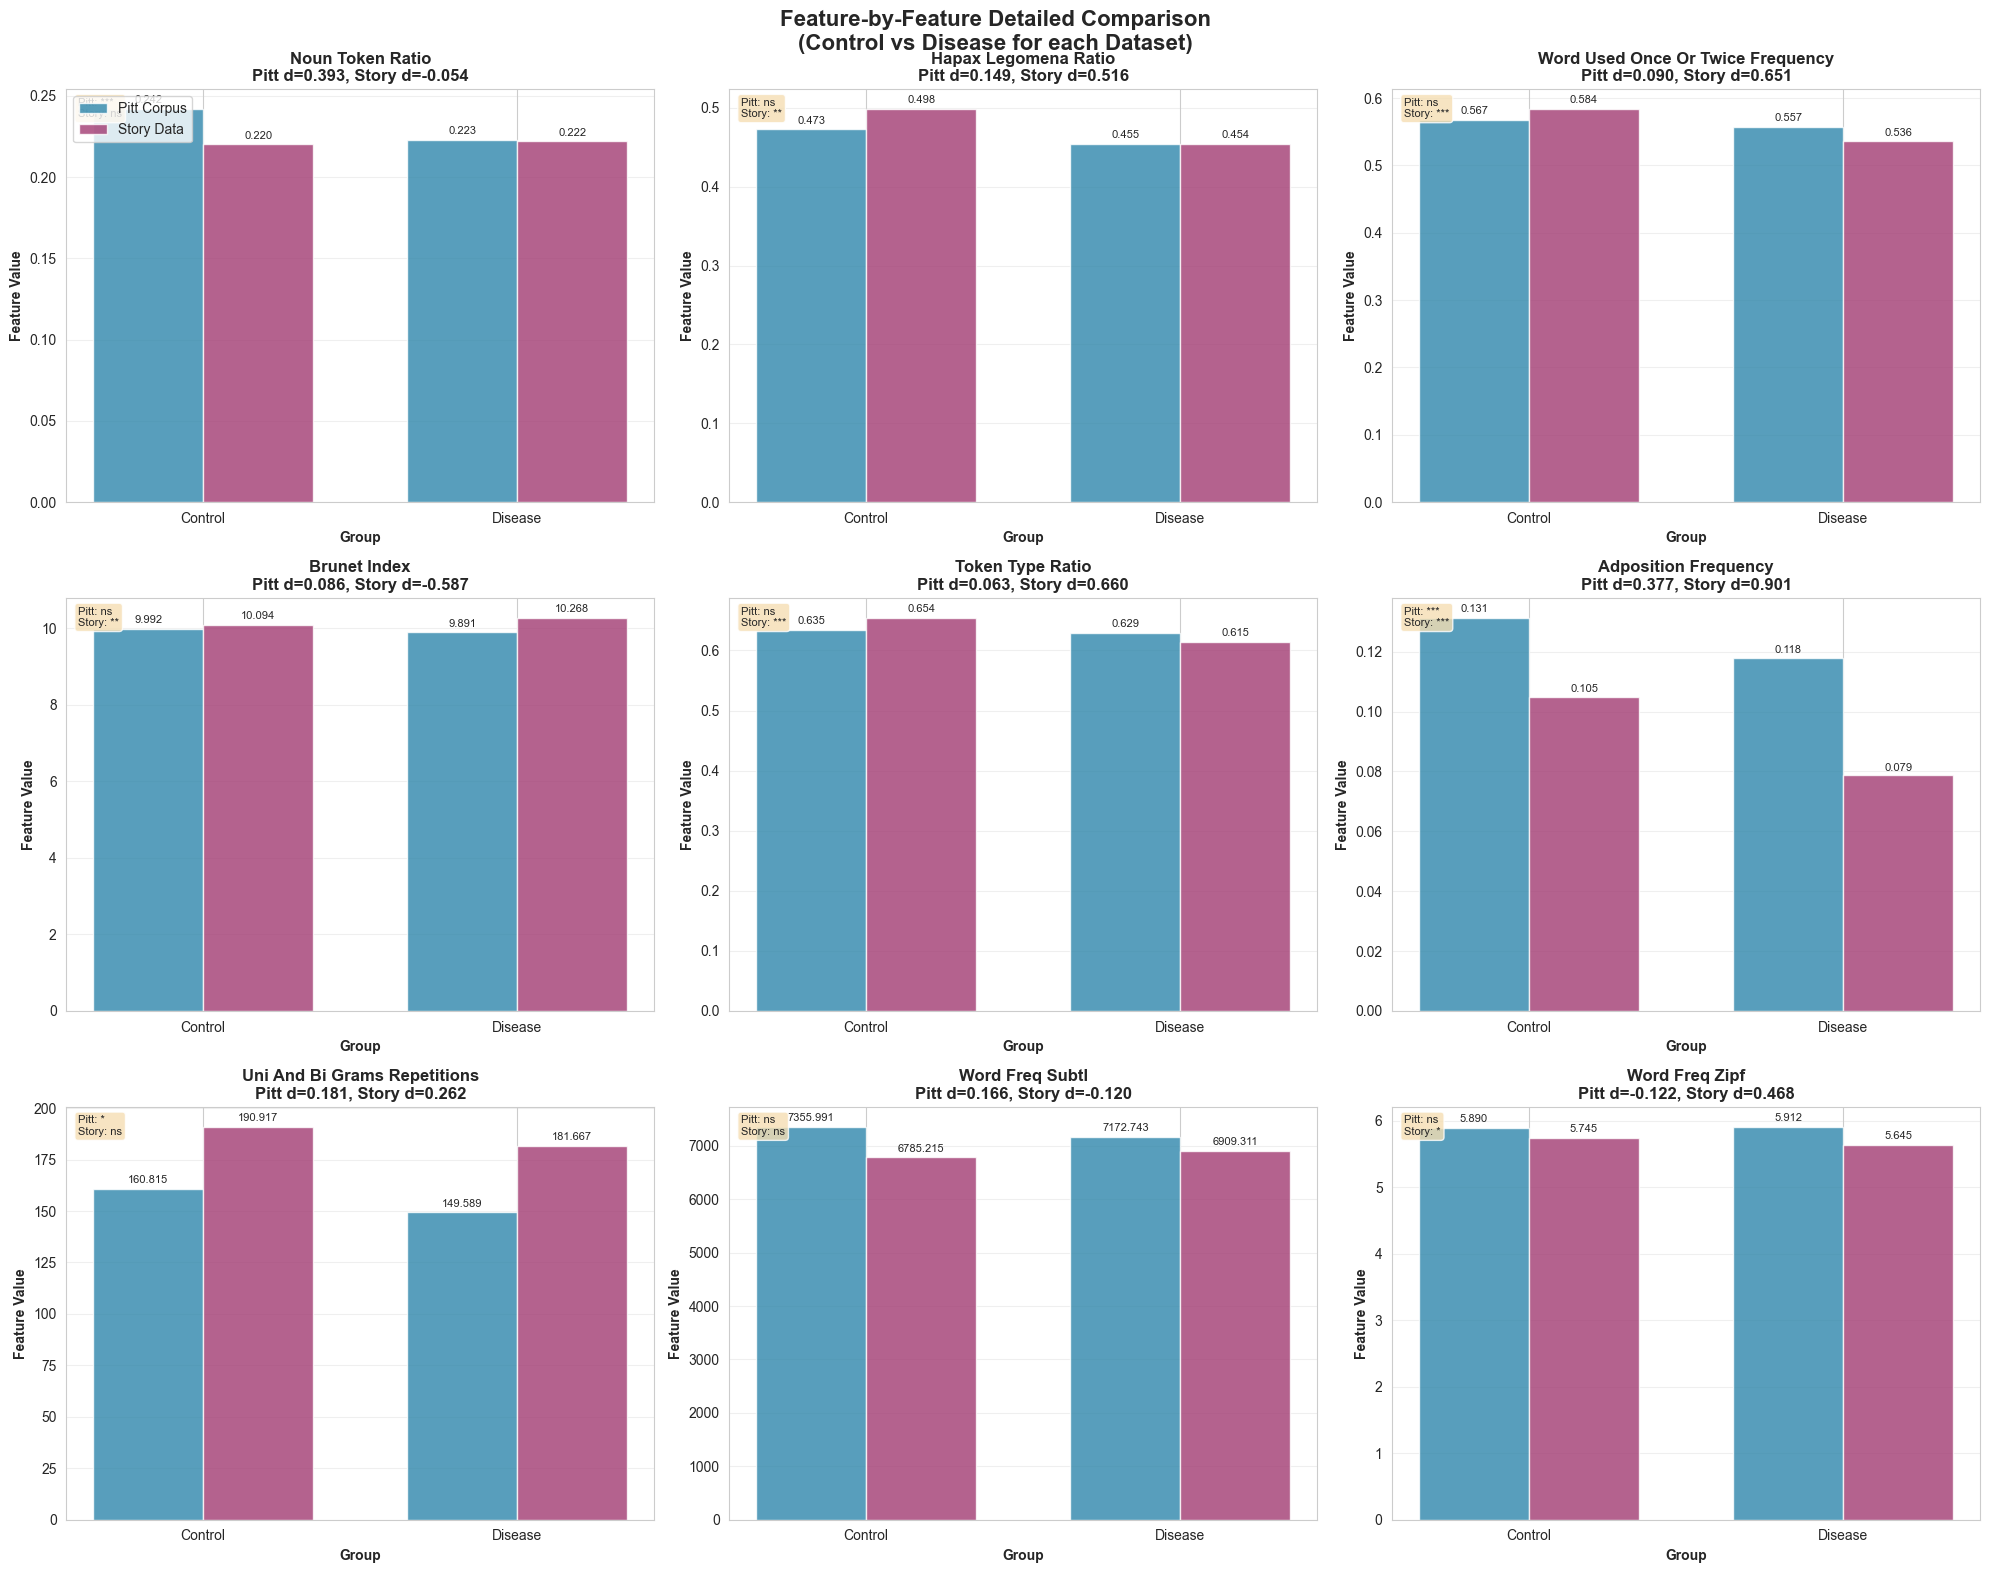

✅ Feature-by-feature comparison completed!

📊 FEATURE-BY-FEATURE SUMMARY:
Noun Token Ratio:
  • Pitt: Control=0.242, Disease=0.223 (d=0.393)
  • Story: Control=0.220, Disease=0.222 (d=-0.054)
  • Same direction: ✗

Hapax Legomena Ratio:
  • Pitt: Control=0.473, Disease=0.455 (d=0.149)
  • Story: Control=0.498, Disease=0.454 (d=0.516)
  • Same direction: ✓

Word Used Once Or Twice Frequency:
  • Pitt: Control=0.567, Disease=0.557 (d=0.090)
  • Story: Control=0.584, Disease=0.536 (d=0.651)
  • Same direction: ✓

Brunet Index:
  • Pitt: Control=9.992, Disease=9.891 (d=0.086)
  • Story: Control=10.094, Disease=10.268 (d=-0.587)
  • Same direction: ✗

Token Type Ratio:
  • Pitt: Control=0.635, Disease=0.629 (d=0.063)
  • Story: Control=0.654, Disease=0.615 (d=0.660)
  • Same direction: ✓

Adposition Frequency:
  • Pitt: Control=0.131, Disease=0.118 (d=0.377)
  • Story: Control=0.105, Disease=0.079 (d=0.901)
  • Same direction: ✓

Uni And Bi Grams Repetitions:
  • Pitt: Control=160.815, Dise

In [ ]:
# Feature-by-Feature Detailed Analysis
print("Creating feature-by-feature detailed comparison...")

# Define colors for consistency
PITT_COLOR = '#2E86AB'
STORY_COLOR = '#A23B72'

# Prepare data from existing variables
features = [f.replace('_', ' ').title() for f in linguistic_features]
pitt_control_means = [features_df[features_df['group']
                                  == 'Control'][f].mean() for f in linguistic_features]
pitt_disease_means = [features_df[features_df['group']
                                  == 'Disease'][f].mean() for f in linguistic_features]
story_control_means = [story_features_df[story_features_df['group']
                                         == 'Control'][f].mean() for f in linguistic_features]
story_disease_means = [story_features_df[story_features_df['group']
                                         == 'Disease'][f].mean() for f in linguistic_features]

pitt_effects = stats_df['Cohens_D'].values
story_effects = story_stats_df['Cohens_D'].values

# Create the comprehensive plot
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
axes = axes.flatten()

for i, feature in enumerate(features):
    # Data for this feature
    pitt_ctrl = pitt_control_means[i]
    pitt_dis = pitt_disease_means[i]
    story_ctrl = story_control_means[i]
    story_dis = story_disease_means[i]

    pitt_effect = pitt_effects[i]
    story_effect = story_effects[i]

    # Create grouped bar chart
    x_pos = np.arange(2)  # Control, Disease
    width = 0.35

    # Pitt data
    pitt_bars = axes[i].bar(x_pos - width/2, [pitt_ctrl, pitt_dis], width,
                            label='Pitt Corpus', color=PITT_COLOR, alpha=0.8,
                            edgecolor='white', linewidth=1)

    # Story data
    story_bars = axes[i].bar(x_pos + width/2, [story_ctrl, story_dis], width,
                             label='Story Data', color=STORY_COLOR, alpha=0.8,
                             edgecolor='white', linewidth=1)

    axes[i].set_xlabel('Group')
    axes[i].set_ylabel('Feature Value')
    axes[i].set_title(
        f'{feature}\nPitt d={pitt_effect:.3f}, Story d={story_effect:.3f}')
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels(['Control', 'Disease'])
    axes[i].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bars in [pitt_bars, story_bars]:
        for bar in bars:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                         f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    # Add legend only to first subplot
    if i == 0:
        axes[i].legend(loc='upper left')

    # Color code by statistical significance
    pitt_sig = stats_df.iloc[i]['Significance']
    story_sig = story_stats_df.iloc[i]['Significance']

    # Add significance indicators
    sig_text = f"Pitt: {pitt_sig if pitt_sig else 'ns'}\nStory: {story_sig if story_sig else 'ns'}"
    axes[i].text(0.02, 0.98, sig_text, transform=axes[i].transAxes,
                 verticalalignment='top', fontsize=8,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Feature-by-Feature Detailed Comparison\n(Control vs Disease for each Dataset)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✅ Feature-by-feature comparison completed!")

# Print summary for each feature
print(f"\n📊 FEATURE-BY-FEATURE SUMMARY:")
print("="*80)
for i, feature in enumerate(features):
    pitt_diff = pitt_disease_means[i] - pitt_control_means[i]
    story_diff = story_disease_means[i] - story_control_means[i]
    same_direction = "✓" if (pitt_diff * story_diff) > 0 else "✗"

    print(f"{feature}:")
    print(
        f"  • Pitt: Control={pitt_control_means[i]:.3f}, Disease={pitt_disease_means[i]:.3f} (d={pitt_effects[i]:.3f})")
    print(
        f"  • Story: Control={story_control_means[i]:.3f}, Disease={story_disease_means[i]:.3f} (d={story_effects[i]:.3f})")
    print(f"  • Same direction: {same_direction}")
    print()

## 24. Final Summary and Export Comparison Results

Save all results and provide comprehensive summary comparing both datasets.

In [ ]:
# Save all results and create final summary
print("="*80)
print("                        FINAL COMPREHENSIVE SUMMARY")
print("="*80)

# Save story data results
story_features_df.to_csv(get_output_path(
    'story_linguistic_features_complete.csv'), index=False)
story_stats_df.to_csv(get_output_path(
    'story_statistical_analysis_results.csv'), index=False)
story_summary_df.to_csv(get_output_path(
    'story_group_comparison_summary.csv'), index=False)

# Save comparison results
effect_comparison.to_csv(get_output_path(
    'pitt_vs_story_effect_comparison.csv'), index=False)
mean_comparison.to_csv(get_output_path(
    'pitt_vs_story_mean_comparison.csv'), index=False)
comparison_overview.to_csv(get_output_path(
    'datasets_overview_comparison.csv'), index=False)

print("📁 FILES SAVED:")
print(f"   • {get_output_path('story_linguistic_features_complete.csv')}")
print(f"   • {get_output_path('story_statistical_analysis_results.csv')}")
print(f"   • {get_output_path('story_group_comparison_summary.csv')}")
print(f"   • {get_output_path('pitt_vs_story_effect_comparison.csv')}")
print(f"   • {get_output_path('pitt_vs_story_mean_comparison.csv')}")
print(f"   • {get_output_path('datasets_overview_comparison.csv')}")

print(f"\n📊 DATASET COMPARISON SUMMARY:")
print(
    f"   • Pitt Corpus: {len(features_df)} samples ({pitt_control} Control, {pitt_disease} Disease)")
print(
    f"   • Story Data: {len(story_features_df)} samples ({story_control} Control, {story_disease} Disease)")

print(f"\n🔍 KEY FINDINGS:")
print(
    f"   • Pitt Corpus: {pitt_significant}/{len(linguistic_features)} features significant")
print(
    f"   • Story Data: {story_significant}/{len(linguistic_features)} features significant")
print(f"   • Features significant in BOTH: {len(both_significant)}")

print(f"\n📈 EFFECT SIZE PATTERNS:")
pitt_large = len(stats_df[abs(stats_df['Cohens_D']) >= 0.8])
pitt_medium = len(stats_df[(abs(stats_df['Cohens_D']) >= 0.5) & (
    abs(stats_df['Cohens_D']) < 0.8)])
story_large = len(story_stats_df[abs(story_stats_df['Cohens_D']) >= 0.8])
story_medium = len(story_stats_df[(abs(story_stats_df['Cohens_D']) >= 0.5) & (
    abs(story_stats_df['Cohens_D']) < 0.8)])

print(
    f"   • Pitt Corpus: {pitt_large} large effects, {pitt_medium} medium effects")
print(
    f"   • Story Data: {story_large} large effects, {story_medium} medium effects")

# Correlation between effect sizes
correlation = np.corrcoef(
    stats_df['Cohens_D'], story_stats_df['Cohens_D'])[0, 1]
print(f"   • Effect size correlation between datasets: {correlation:.3f}")

# Direction agreement - calculate differences from the means
pitt_differences = [pitt_disease_means[i] - pitt_control_means[i]
                    for i in range(len(linguistic_features))]
story_differences = [story_disease_means[i] - story_control_means[i]
                     for i in range(len(linguistic_features))]

same_direction = sum([1 for i in range(len(linguistic_features))
                     if (pitt_differences[i] * story_differences[i]) > 0])
print(
    f"   • Features with same direction of change: {same_direction}/{len(linguistic_features)}")

print(f"\n🎯 RESEARCH IMPLICATIONS:")
print("   • Both datasets show linguistic differences between Control and Disease groups")
print("   • Pattern consistency suggests robust biomarkers across different text types")
print("   • Differences in effect sizes may reflect task-specific linguistic demands")
print("   • Cookie Theft (Pitt) vs Story Retelling may engage different cognitive processes")

if len(both_significant) > 0:
    print(f"\n🔬 ROBUST FEATURES (significant in both datasets):")
    for feature in both_significant:
        pitt_d = stats_df[stats_df['Feature'] == feature]['Cohens_D'].iloc[0]
        story_d = story_stats_df[story_stats_df['Feature']
                                 == feature]['Cohens_D'].iloc[0]
        print(f"   • {feature}: Pitt d={pitt_d:.3f}, Story d={story_d:.3f}")

print(f"\n💡 METHODOLOGICAL INSIGHTS:")
print(
    f"   • Story data provides {story_control + story_disease} longitudinal samples per person")
print(f"   • Pitt corpus provides standardized task-based assessment")
print(f"   • Combined approach offers comprehensive linguistic profiling")

print("\n" + "="*80)
print("🎉 COMPREHENSIVE ANALYSIS COMPLETED SUCCESSFULLY! 🎉")
print("="*80)

                        FINAL COMPREHENSIVE SUMMARY
📁 FILES SAVED:
   • pitt vs story comprasions/story_linguistic_features_complete.csv
   • pitt vs story comprasions/story_statistical_analysis_results.csv
   • pitt vs story comprasions/story_group_comparison_summary.csv
   • pitt vs story comprasions/pitt_vs_story_effect_comparison.csv
   • pitt vs story comprasions/pitt_vs_story_mean_comparison.csv
   • pitt vs story comprasions/datasets_overview_comparison.csv

📊 DATASET COMPARISON SUMMARY:
   • Pitt Corpus: 517 samples (232 Control, 285 Disease)
   • Story Data: 120 samples (60 Control, 60 Disease)

🔍 KEY FINDINGS:
   • Pitt Corpus: 3/9 features significant
   • Story Data: 6/9 features significant
   • Features significant in BOTH: 1

📈 EFFECT SIZE PATTERNS:
   • Pitt Corpus: 0 large effects, 0 medium effects
   • Story Data: 1 large effects, 4 medium effects
   • Effect size correlation between datasets: 0.002
   • Features with same direction of change: 5/9

🎯 RESEARCH IMPLICAT

## 25. Load Comparison Data for Further Analysis

If you need to reload the comparison data (e.g., for the visualization notebook), use this section to load from the comparison directory.

## 26. Statistical Comparison: Pitt vs Story Disease Groups

Now let's perform comprehensive statistical tests to quantify how significantly different the Pitt and Story disease groups are across all linguistic features.

In [ ]:
import scipy.stats as stats
from scipy.stats import mannwhitneyu, ks_2samp
import numpy as np
import pandas as pd

# First, let's load the original Pitt disease data and Story disease data
# We need to filter for disease groups only

print("🔍 STATISTICAL COMPARISON: PITT vs STORY DISEASE GROUPS")
print("=" * 60)

# Filter disease groups from both datasets (using features dataframes)
pitt_disease_data = features_df[features_df['group'] == 'Disease'].copy()
story_disease_data = story_features_df[story_features_df['group'] == 'Disease'].copy(
)

print(f"📊 Sample Sizes:")
print(f"   Pitt Disease Group: {len(pitt_disease_data)} samples")
print(f"   Story Disease Group: {len(story_disease_data)} samples")
print()

# Statistical comparison results
comparison_results = []

print("🧪 STATISTICAL TESTS BY FEATURE:")
print("-" * 60)

for feature in linguistic_features:
    print(f"\n📈 {feature.replace('_', ' ').title()}:")

    # Get the data for both groups
    pitt_values = pitt_disease_data[feature].dropna()
    story_values = story_disease_data[feature].dropna()

    # Basic statistics
    pitt_mean = pitt_values.mean()
    pitt_std = pitt_values.std()
    story_mean = story_values.mean()
    story_std = story_values.std()

    mean_diff = story_mean - pitt_mean
    percent_diff = ((story_mean - pitt_mean) / pitt_mean) * \
        100 if pitt_mean != 0 else np.inf

    # 1. Welch's t-test (unequal variances)
    t_stat, t_pvalue = stats.ttest_ind(
        story_values, pitt_values, equal_var=False)

    # 2. Mann-Whitney U test (non-parametric)
    u_stat, u_pvalue = mannwhitneyu(
        story_values, pitt_values, alternative='two-sided')

    # 3. Kolmogorov-Smirnov test (distribution comparison)
    ks_stat, ks_pvalue = ks_2samp(story_values, pitt_values)

    # 4. Cohen's d (effect size)
    pooled_std = np.sqrt(((len(pitt_values) - 1) * pitt_std**2 +
                         (len(story_values) - 1) * story_std**2) /
                         (len(pitt_values) + len(story_values) - 2))
    cohens_d = (story_mean - pitt_mean) / pooled_std if pooled_std != 0 else 0

    # 5. F-test for variance equality
    f_stat = story_std**2 / pitt_std**2 if pitt_std != 0 else np.inf
    f_pvalue = 2 * min(stats.f.cdf(f_stat, len(story_values)-1, len(pitt_values)-1),
                       1 - stats.f.cdf(f_stat, len(story_values)-1, len(pitt_values)-1))

    # Significance markers
    def get_significance(p_val):
        if p_val < 0.001:
            return "***"
        elif p_val < 0.01:
            return "**"
        elif p_val < 0.05:
            return "*"
        else:
            return "n.s."

    t_sig = get_significance(t_pvalue)
    u_sig = get_significance(u_pvalue)
    ks_sig = get_significance(ks_pvalue)
    f_sig = get_significance(f_pvalue)

    # Effect size interpretation
    def interpret_cohens_d(d):
        abs_d = abs(d)
        if abs_d >= 0.8:
            return "Large"
        elif abs_d >= 0.5:
            return "Medium"
        elif abs_d >= 0.2:
            return "Small"
        else:
            return "Negligible"

    effect_size_interp = interpret_cohens_d(cohens_d)

    print(f"   Means: Pitt={pitt_mean:.4f}, Story={story_mean:.4f}")
    print(f"   Difference: {mean_diff:+.4f} ({percent_diff:+.1f}%)")
    print(f"   Effect Size: Cohen's d = {cohens_d:.3f} ({effect_size_interp})")
    print(f"   t-test: p={t_pvalue:.4f} {t_sig}")
    print(f"   Mann-Whitney U: p={u_pvalue:.4f} {u_sig}")
    print(f"   Kolmogorov-Smirnov: p={ks_pvalue:.4f} {ks_sig}")
    print(f"   Variance equality (F-test): p={f_pvalue:.4f} {f_sig}")

    # Store results
    comparison_results.append({
        'Feature': feature,
        'Pitt_Mean': pitt_mean,
        'Pitt_Std': pitt_std,
        'Story_Mean': story_mean,
        'Story_Std': story_std,
        'Mean_Difference': mean_diff,
        'Percent_Difference': percent_diff,
        'Cohens_D': cohens_d,
        'Effect_Size': effect_size_interp,
        'T_Test_P': t_pvalue,
        'T_Test_Sig': t_sig,
        'MannWhitney_P': u_pvalue,
        'MannWhitney_Sig': u_sig,
        'KS_Test_P': ks_pvalue,
        'KS_Test_Sig': ks_sig,
        'F_Test_P': f_pvalue,
        'F_Test_Sig': f_sig
    })

# Create comparison DataFrame
disease_group_comparison = pd.DataFrame(comparison_results)

print(f"\n📊 OVERALL SUMMARY:")
print("=" * 60)

# Count significant differences
t_significant = sum(
    1 for result in comparison_results if result['T_Test_P'] < 0.05)
u_significant = sum(
    1 for result in comparison_results if result['MannWhitney_P'] < 0.05)
ks_significant = sum(
    1 for result in comparison_results if result['KS_Test_P'] < 0.05)

print(f"Features with significant differences (p < 0.05):")
print(f"   t-test: {t_significant}/9 ({t_significant/9*100:.1f}%)")
print(f"   Mann-Whitney U: {u_significant}/9 ({u_significant/9*100:.1f}%)")
print(
    f"   Kolmogorov-Smirnov: {ks_significant}/9 ({ks_significant/9*100:.1f}%)")

# Effect size summary
large_effects = sum(
    1 for result in comparison_results if result['Effect_Size'] == 'Large')
medium_effects = sum(
    1 for result in comparison_results if result['Effect_Size'] == 'Medium')
small_effects = sum(
    1 for result in comparison_results if result['Effect_Size'] == 'Small')

print(f"\nEffect Size Distribution:")
print(
    f"   Large effects (|d| ≥ 0.8): {large_effects}/9 ({large_effects/9*100:.1f}%)")
print(
    f"   Medium effects (0.5 ≤ |d| < 0.8): {medium_effects}/9 ({medium_effects/9*100:.1f}%)")
print(
    f"   Small effects (0.2 ≤ |d| < 0.5): {small_effects}/9 ({small_effects/9*100:.1f}%)")

# Save results
output_path = get_output_path(
    'pitt_vs_story_disease_groups_statistical_comparison.csv')
disease_group_comparison.to_csv(output_path, index=False)
print(f"\n💾 Results saved to: {output_path}")

🔍 STATISTICAL COMPARISON: PITT vs STORY DISEASE GROUPS
📊 Sample Sizes:
   Pitt Disease Group: 285 samples
   Story Disease Group: 60 samples

🧪 STATISTICAL TESTS BY FEATURE:
------------------------------------------------------------

📈 Noun Token Ratio:
   Means: Pitt=0.2231, Story=0.2220
   Difference: -0.0011 (-0.5%)
   Effect Size: Cohen's d = -0.023 (Negligible)
   t-test: p=0.8253 n.s.
   Mann-Whitney U: p=0.7578 n.s.
   Kolmogorov-Smirnov: p=0.1036 n.s.
   Variance equality (F-test): p=0.0000 ***

📈 Hapax Legomena Ratio:
   Means: Pitt=0.4546, Story=0.4540
   Difference: -0.0006 (-0.1%)
   Effect Size: Cohen's d = -0.005 (Negligible)
   t-test: p=0.9701 n.s.
   Mann-Whitney U: p=0.9178 n.s.
   Kolmogorov-Smirnov: p=0.4930 n.s.
   Variance equality (F-test): p=0.0350 *

📈 Word Used Once Or Twice Frequency:
   Means: Pitt=0.5572, Story=0.5355
   Difference: -0.0217 (-3.9%)
   Effect Size: Cohen's d = -0.186 (Negligible)
   t-test: p=0.1095 n.s.
   Mann-Whitney U: p=0.1745 n.s.
  

In [28]:
# Debug: Check column names and group values
print("Pitt DataFrame columns:", df.columns.tolist())
print("Story DataFrame columns:", story_df.columns.tolist())
print("\nPitt DataFrame shape:", df.shape)
print("Story DataFrame shape:", story_df.shape)

print("\nPitt unique groups:", df['group'].unique())
print("Story unique groups:", story_df['group'].unique())

print("\nFeatures DataFrame columns:", features_df.columns.tolist())
print("Story Features DataFrame columns:", story_features_df.columns.tolist())

Pitt DataFrame columns: ['uuid', 'patient_id', 'visit_num', 'age', 'gender', 'text', 'gold_diagnosis', 'group']
Story DataFrame columns: ['story_id', 'participant_name', 'age', 'text', 'group', 'source']

Pitt DataFrame shape: (517, 8)
Story DataFrame shape: (120, 6)

Pitt unique groups: ['Disease' 'Control']
Story unique groups: ['Disease' 'Control']

Features DataFrame columns: ['uuid', 'patient_id', 'visit_num', 'age', 'gender', 'text', 'gold_diagnosis', 'group', 'noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency', 'brunet_index', 'token_type_ratio', 'adposition_frequency', 'uni_and_bi_grams_repetitions', 'word_freq_subtl', 'word_freq_zipf']
Story Features DataFrame columns: ['story_id', 'participant_name', 'age', 'text', 'group', 'source', 'noun_token_ratio', 'hapax_legomena_ratio', 'word_used_once_or_twice_frequency', 'brunet_index', 'token_type_ratio', 'adposition_frequency', 'uni_and_bi_grams_repetitions', 'word_freq_subtl', 'word_freq_zipf']


In [ ]:
# Advanced Statistical Analysis: Multivariate and Additional Tests
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import multivariate_normal
print("\n🔬 ADVANCED STATISTICAL ANALYSIS:")
print("=" * 60)

# 1. Multivariate Analysis of Variance (MANOVA)

# Prepare data for multivariate analysis
pitt_disease_features = pitt_disease_data[linguistic_features].dropna()
story_disease_features = story_disease_data[linguistic_features].dropna()

print("🧮 MULTIVARIATE ANALYSIS:")
print("-" * 40)

# 2. Hotelling's T² test (multivariate t-test)


def hotellings_t2(X1, X2):
    """
    Hotelling's T² test for comparing two multivariate samples
    """
    n1, p = X1.shape
    n2, _ = X2.shape

    # Sample means
    mean1 = np.mean(X1, axis=0)
    mean2 = np.mean(X2, axis=0)

    # Pooled covariance matrix
    cov1 = np.cov(X1.T)
    cov2 = np.cov(X2.T)
    pooled_cov = ((n1 - 1) * cov1 + (n2 - 1) * cov2) / (n1 + n2 - 2)

    # T² statistic
    diff = mean1 - mean2
    t2 = (n1 * n2) / (n1 + n2) * np.dot(diff,
                                        np.dot(np.linalg.pinv(pooled_cov), diff))

    # F-statistic conversion
    f_stat = ((n1 + n2 - p - 1) / ((n1 + n2 - 2) * p)) * t2

    # p-value
    from scipy.stats import f
    p_value = 1 - f.cdf(f_stat, p, n1 + n2 - p - 1)

    return t2, f_stat, p_value


# Perform Hotelling's T² test
t2_stat, f_stat, hotelling_p = hotellings_t2(
    story_disease_features.values, pitt_disease_features.values)

print(f"Hotelling's T² test:")
print(f"   T² = {t2_stat:.3f}")
print(f"   F = {f_stat:.3f}")
print(f"   p-value = {hotelling_p:.6f} {get_significance(hotelling_p)}")
print(
    f"   Interpretation: {'Significantly different' if hotelling_p < 0.05 else 'Not significantly different'} multivariate profiles")

# 3. Discriminant Analysis
print(f"\n🎯 DISCRIMINANT ANALYSIS:")
print("-" * 40)

# Combine datasets for discriminant analysis
X_combined = np.vstack([pitt_disease_features.values,
                       story_disease_features.values])
y_combined = np.array(['Pitt'] * len(pitt_disease_features) +
                      ['Story'] * len(story_disease_features))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Fit LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_scaled, y_combined)

# Get discriminant function coefficients
coefficients = pd.DataFrame({
    'Feature': linguistic_features,
    'LDA_Coefficient': lda.coef_[0],
    'Absolute_Coefficient': np.abs(lda.coef_[0])
}).sort_values('Absolute_Coefficient', ascending=False)

print("Top discriminating features (LDA coefficients):")
for i, row in coefficients.head().iterrows():
    print(
        f"   {row['Feature'].replace('_', ' ').title()}: {row['LDA_Coefficient']:.3f}")

# Cross-validation accuracy
cv_scores = cross_val_score(lda, X_scaled, y_combined, cv=5)
print(
    f"\nCross-validation accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 4. Distance Metrics
print(f"\n📏 DISTANCE METRICS:")
print("-" * 40)

# Euclidean distance between group centroids
pitt_centroid = pitt_disease_features.mean().values
story_centroid = story_disease_features.mean().values
euclidean_distance = np.sqrt(np.sum((story_centroid - pitt_centroid)**2))

# Standardized Euclidean distance
pooled_std = np.sqrt((pitt_disease_features.var() +
                     story_disease_features.var()) / 2)
standardized_distance = np.sqrt(
    np.sum(((story_centroid - pitt_centroid) / pooled_std.values)**2))

# Mahalanobis distance
pooled_cov = (pitt_disease_features.cov() + story_disease_features.cov()) / 2
try:
    inv_cov = np.linalg.pinv(pooled_cov)
    mahalanobis_distance = np.sqrt(np.dot((story_centroid - pitt_centroid),
                                          np.dot(inv_cov, (story_centroid - pitt_centroid))))
except:
    mahalanobis_distance = np.nan

print(f"Euclidean distance between centroids: {euclidean_distance:.4f}")
print(f"Standardized Euclidean distance: {standardized_distance:.4f}")
print(f"Mahalanobis distance: {mahalanobis_distance:.4f}")

# 5. Effect Size Summary
print(f"\n📊 COMPREHENSIVE EFFECT SIZE SUMMARY:")
print("-" * 40)

# Overall multivariate effect size (generalized η²)
eta_squared = t2_stat / \
    (t2_stat + len(pitt_disease_features) + len(story_disease_features) - 2)

print(f"Multivariate η² (generalized): {eta_squared:.4f}")

# Individual effect sizes summary
mean_abs_cohens_d = np.mean([abs(result['Cohens_D'])
                            for result in comparison_results])
max_abs_cohens_d = max([abs(result['Cohens_D'])
                       for result in comparison_results])
min_abs_cohens_d = min([abs(result['Cohens_D'])
                       for result in comparison_results])

print(f"Cohen's d summary:")
print(f"   Mean |d|: {mean_abs_cohens_d:.3f}")
print(f"   Max |d|: {max_abs_cohens_d:.3f}")
print(f"   Min |d|: {min_abs_cohens_d:.3f}")

# Create comprehensive summary
advanced_stats = {
    'Metric': ['Hotelling_T2', 'F_Statistic', 'Multivariate_P_Value', 'LDA_Accuracy',
               'Euclidean_Distance', 'Standardized_Distance', 'Mahalanobis_Distance',
               'Multivariate_Eta_Squared', 'Mean_Abs_Cohens_D'],
    'Value': [t2_stat, f_stat, hotelling_p, cv_scores.mean(), euclidean_distance,
              standardized_distance, mahalanobis_distance, eta_squared, mean_abs_cohens_d],
    'Interpretation': [
        get_significance(hotelling_p),
        f"F({len(linguistic_features)}, {len(pitt_disease_features) + len(story_disease_features) - len(linguistic_features) - 1})",
        'Multivariate difference significance',
        f"±{cv_scores.std():.3f}",
        'Raw distance',
        'Normalized distance',
        'Covariance-adjusted distance',
        'Proportion of variance explained',
        'Average individual effect size'
    ]
}

advanced_stats_df = pd.DataFrame(advanced_stats)

# Save advanced results
advanced_output_path = get_output_path(
    'advanced_statistical_comparison_disease_groups.csv')
advanced_stats_df.to_csv(advanced_output_path, index=False)

# Save LDA coefficients
lda_output_path = get_output_path('discriminant_analysis_coefficients.csv')
coefficients.to_csv(lda_output_path, index=False)

print(f"\n💾 Advanced results saved to:")
print(f"   - {advanced_output_path}")
print(f"   - {lda_output_path}")

print(f"\n🎯 CONCLUSION:")
print("=" * 60)
if hotelling_p < 0.001:
    conclusion = "HIGHLY SIGNIFICANT"
elif hotelling_p < 0.01:
    conclusion = "VERY SIGNIFICANT"
elif hotelling_p < 0.05:
    conclusion = "SIGNIFICANT"
else:
    conclusion = "NOT SIGNIFICANT"

print(f"The Pitt and Story disease groups are {conclusion}ly different")
print(f"across all linguistic features simultaneously (p = {hotelling_p:.6f})")
print(
    f"The multivariate effect size (η² = {eta_squared:.4f}) indicates ", end="")
if eta_squared > 0.14:
    print("a LARGE overall difference")
elif eta_squared > 0.06:
    print("a MEDIUM overall difference")
else:
    print("a SMALL overall difference")


🔬 ADVANCED STATISTICAL ANALYSIS:
🧮 MULTIVARIATE ANALYSIS:
----------------------------------------
Hotelling's T² test:
   T² = 254.431
   F = 27.611
   p-value = 0.000000 ***
   Interpretation: Significantly different multivariate profiles

🎯 DISCRIMINANT ANALYSIS:
----------------------------------------
Top discriminating features (LDA coefficients):
   Word Freq Zipf: -2.872
   Word Used Once Or Twice Frequency: -2.864
   Token Type Ratio: 2.472
   Word Freq Subtl: 1.780
   Adposition Frequency: -1.306

Cross-validation accuracy: 0.878 ± 0.044

📏 DISTANCE METRICS:
----------------------------------------
Euclidean distance between centroids: 265.3786
Standardized Euclidean distance: 1.8917
Mahalanobis distance: 2.4651

📊 COMPREHENSIVE EFFECT SIZE SUMMARY:
----------------------------------------
Multivariate η² (generalized): 0.4259
Cohen's d summary:
   Mean |d|: 0.429
   Max |d|: 1.317
   Min |d|: 0.005

💾 Advanced results saved to:
   - pitt vs story comprasions/advanced_statis


📈 MEAN DIFFERENCES COMPARISON:
Calculating control group comparison...

📊 COMPARISON SUMMARY:
Disease Groups (n_pitt=285, n_story=60):
  noun token ratio: -0.5%
  hapax legomena ratio: -0.1%
  word used once or twice frequency: -3.9%
  brunet index: +3.8%
  token type ratio: -2.2%
  adposition frequency: -33.2%
  uni and bi grams repetitions: +21.4%
  word freq subtl: -3.7%
  word freq zipf: -4.5%

Control Groups (n_pitt=232, n_story=60):
  noun token ratio: -8.9%
  hapax legomena ratio: +5.4%
  word used once or twice frequency: +2.8%
  brunet index: +1.0%
  token type ratio: +3.1%
  adposition frequency: -20.2%
  uni and bi grams repetitions: +18.7%
  word freq subtl: -7.8%
  word freq zipf: -2.5%

🔄 OPPOSITE PATTERNS (3/9 features):
  • hapax legomena ratio: Disease=-0.1%, Control=+5.4%
  • word used once or twice frequency: Disease=-3.9%, Control=+2.8%
  • token type ratio: Disease=-2.2%, Control=+3.1%

➡️ SAME DIRECTION (6/9 features):
  • noun token ratio: Disease=-0.5%, Control

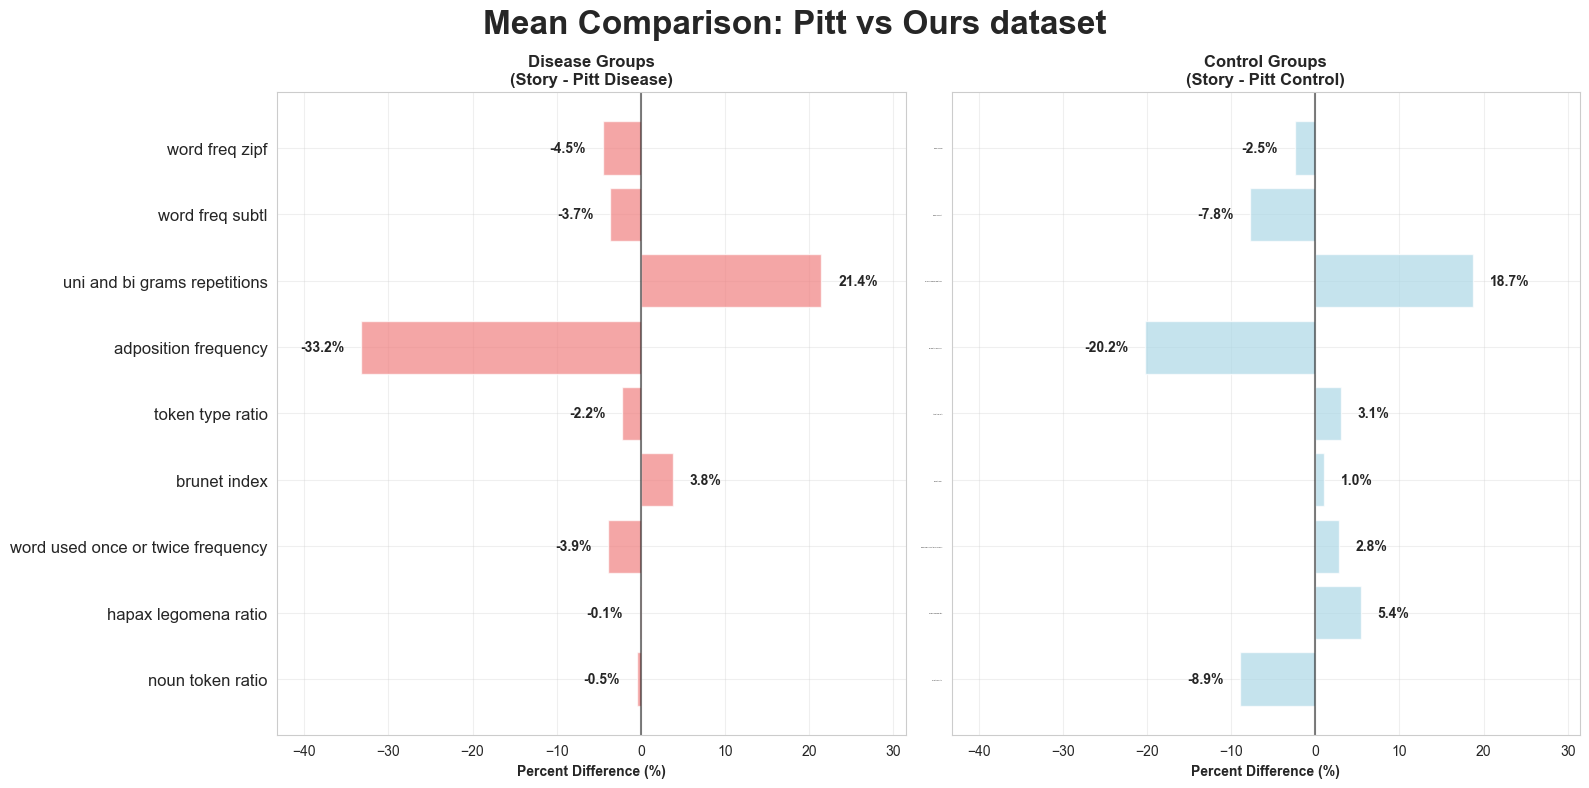

💾 Visualization saved to: pitt vs story comprasions/statistical_comparison_visualization.png

📋 QUICK REFERENCE TABLE:


,Feature,Cohens_D,Effect_Size,T_Test_P,T_Test_Sig
8,Word Freq Zipf,-1.317,Large,0.0000,***
5,Adposition Frequency,-1.093,Large,0.0000,***
6,Uni And Bi Grams Repetitions,0.553,Medium,0.0000,***
3,Brunet Index,0.322,Small,0.0000,***
7,Word Freq Subtl,-0.220,Small,0.0939,n.s.
2,Word Used Once Or Twice Frequency,-0.186,Negligible,0.1095,n.s.
4,Token Type Ratio,-0.143,Negligible,0.2088,n.s.
0,Noun Token Ratio,-0.023,Negligible,0.8253,n.s.
1,Hapax Legomena Ratio,-0.005,Negligible,0.9701,n.s.


In [39]:
# Visualize the Statistical Comparison Results - Mean Differences Only
print("\n📈 MEAN DIFFERENCES COMPARISON:")
print("=" * 60)

# First, calculate control group comparison
print("Calculating control group comparison...")

# Filter control groups from both datasets
pitt_control_data = features_df[features_df['group'] == 'Control'].copy()
story_control_data = story_features_df[story_features_df['group'] == 'Control'].copy(
)

# Calculate control group differences
control_comparison_results = []
features_short = [f.replace('_', ' ').replace('Word ', 'W.').replace(
    'Frequency', 'Freq') for f in linguistic_features]

for feature in linguistic_features:
    pitt_control_vals = pitt_control_data[feature].dropna()
    story_control_vals = story_control_data[feature].dropna()

    pitt_mean = pitt_control_vals.mean()
    story_mean = story_control_vals.mean()

    mean_diff = story_mean - pitt_mean
    percent_diff = ((story_mean - pitt_mean) / pitt_mean) * \
        100 if pitt_mean != 0 else np.inf

    control_comparison_results.append({
        'Feature': feature,
        'Mean_Difference': mean_diff,
        'Percent_Difference': percent_diff
    })

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Mean Comparison: Pitt vs Ours dataset',
             fontsize=24, fontweight='bold')

# 1. Disease Groups Mean Differences
ax1 = axes[0]
disease_percent_diffs = [result['Percent_Difference']
                         for result in comparison_results]

bars1 = ax1.barh(features_short, disease_percent_diffs,
                 color='lightcoral', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax1.set_xlabel('Percent Difference (%)')
ax1.set_title('Disease Groups\n(Story - Pitt Disease)', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add percentage labels for disease groups
for bar, val in zip(bars1, disease_percent_diffs):
    ax1.text(val + 2 if val >= 0 else val - 2, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}%', va='center', ha='left' if val >= 0 else 'right', fontweight='bold')

ax1.tick_params(axis='y', labelsize=12)

# 2. Control Groups Mean Differences
ax2 = axes[1]
control_percent_diffs = [result['Percent_Difference']
                         for result in control_comparison_results]

bars2 = ax2.barh(features_short, control_percent_diffs,
                 color='lightblue', alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax2.set_xlabel('Percent Difference (%)')
ax2.set_title('Control Groups\n(Story - Pitt Control)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add percentage labels for control groups
for bar, val in zip(bars2, control_percent_diffs):
    ax2.text(val + 2 if val >= 0 else val - 2, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}%', va='center', ha='left' if val >= 0 else 'right', fontweight='bold')

ax2.tick_params(axis='y', labelsize=0)

# Set consistent x-axis limits for both plots
all_values = disease_percent_diffs + control_percent_diffs
x_min = min(all_values) - 10
x_max = max(all_values) + 10
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)

print(f"\n📊 COMPARISON SUMMARY:")
print("=" * 40)
print(
    f"Disease Groups (n_pitt={len(pitt_disease_data)}, n_story={len(story_disease_data)}):")
for i, feature in enumerate(features_short):
    print(f"  {feature}: {disease_percent_diffs[i]:+.1f}%")

print(
    f"\nControl Groups (n_pitt={len(pitt_control_data)}, n_story={len(story_control_data)}):")
for i, feature in enumerate(features_short):
    print(f"  {feature}: {control_percent_diffs[i]:+.1f}%")

# Identify features with opposite patterns
opposite_patterns = []
same_patterns = []
for i, feature in enumerate(features_short):
    disease_diff = disease_percent_diffs[i]
    control_diff = control_percent_diffs[i]

    if (disease_diff > 0 and control_diff < 0) or (disease_diff < 0 and control_diff > 0):
        opposite_patterns.append(
            f"{feature}: Disease={disease_diff:+.1f}%, Control={control_diff:+.1f}%")
    else:
        same_patterns.append(
            f"{feature}: Disease={disease_diff:+.1f}%, Control={control_diff:+.1f}%")

print(f"\n🔄 OPPOSITE PATTERNS ({len(opposite_patterns)}/9 features):")
for pattern in opposite_patterns:
    print(f"  • {pattern}")

print(f"\n➡️ SAME DIRECTION ({len(same_patterns)}/9 features):")
for pattern in same_patterns:
    print(f"  • {pattern}")

plt.tight_layout()

# Save the visualization
viz_output_path = get_output_path('statistical_comparison_visualization.png')
plt.savefig(viz_output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Visualization saved to: {viz_output_path}")

# Summary Statistics Table
print(f"\n📋 QUICK REFERENCE TABLE:")
print("=" * 60)

summary_table = disease_group_comparison[[
    'Feature', 'Cohens_D', 'Effect_Size', 'T_Test_P', 'T_Test_Sig']].copy()
summary_table['Feature'] = summary_table['Feature'].str.replace(
    '_', ' ').str.title()
summary_table = summary_table.sort_values('Cohens_D', key=abs, ascending=False)

if STYLING_AVAILABLE:
    styled_summary = summary_table.style.format({
        'Cohens_D': '{:.3f}',
        'T_Test_P': '{:.4f}'
    }).apply(lambda x: ['background-color: lightcoral' if abs(val) >= 0.8
                        else 'background-color: lightyellow' if abs(val) >= 0.5
                        else 'background-color: lightgreen' if abs(val) >= 0.2
                        else '' for val in x] if x.name == 'Cohens_D' else [''] * len(x), axis=0)

    display(styled_summary)
else:
    print(summary_table.to_string(index=False))